
# **PATTERN RECOGNITION AND MACHINE LEARNING**



## Mid-term Project: Mental Attention States Classification Using EEG Data


## **GIỚI THIỆU**

Dự án này nhằm phân loại các trạng thái chú ý tinh thần—tập trung, không tập trung và buồn ngủ—dựa trên tín hiệu EEG từ thiết bị EMOTIV EEG. Dữ liệu được thu thập từ 34 thí nghiệm, bao gồm tín hiệu EEG từ các kênh 4 đến 17 với tần số mẫu 128 Hz. Các kỹ thuật học máy sẽ được áp dụng để phát triển một mô hình chính xác nhằm phát hiện các trạng thái này. Dữ liệu có sẵn [tại đây](https://www.kaggle.com/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/data).

## **TỔNG QUAN VỀ PHƯƠNG PHÁP**
Để phân loại trạng thái chú ý tinh thần từ tín hiệu EEG, quá trình thường bao gồm các bước chính: xử lý tín hiệu, trích xuất đặc trưng và áp dụng thuật toán học máy. Trong bước xử lý tín hiệu, các kỹ thuật như lọc và loại bỏ nhiễu (đặc biệt là với ICA) giúp cải thiện chất lượng dữ liệu EEG. Sau đó, các đặc trưng như mật độ phổ công suất và các đặc trưng tần số được trích xuất. Cuối cùng, các thuật toán học máy như SVM, Random Forest, cùng các mô hình học sâu như CNN và RNN được sử dụng để phân loại các trạng thái chú ý, giúp cải thiện độ chính xác và hiệu quả của mô hình.

## **TECH STACKS**
* **Ngôn ngữ lập trình (Programming Languages):** Python

* **Thư viện (Libraries):** MNE, Pandas, Numpy, Scikit-Learn, Matplotlib, Seaborn

* **Môi trườnng (IDE):** Visual Studio Code, Google Colab, Jupyter Notebook

* **Công cụ trình bày (Presentation):** Canva, PowerPoint

#### **Libraries we used**

In [134]:
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch, stft
import mne
from mne.preprocessing import ICA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from numpy import blackman
from scipy.stats import entropy
import seaborn as sns

In [135]:
import kagglehub
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Download latest version
path = kagglehub.dataset_download("inancigdem/eeg-data-for-mental-attention-state-detection")

print("Path to dataset files:", path)

# Collect all file names
file_names = []
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        file_names.append(os.path.join(dirname, filename))

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1


## **DATA UNDERSTADING AND CLEANING**

## **Data understanding**

#### **Tổng quan về bộ dữ liệu EEG**

Bộ dữ liệu EEG này được thu thập trong một thử nghiệm với 5 đối tượng (subjects), trong đó mỗi đối tượng thực hiện nhiều thử nghiệm liên tiếp, với mục tiêu khảo sát các trạng thái chú ý tinh thần. Trạng thái chú ý của đối tượng được phân chia thành ba nhóm chính: **tập trung (`focussed`)**, **không tập trung (`unfocussed`)** và **buồn ngủ (`drowsed`)**. Mỗi trạng thái này được ghi nhận trong các khoảng thời gian cụ thể, như mô tả sau:

- **Trạng thái "tập trung" (`focussed`)**: Đại diện cho giai đoạn mà đối tượng thực hiện nhiệm vụ với sự chú ý cao độ. Dữ liệu EEG cho trạng thái này được thu thập trong 10 phút đầu tiên của mỗi thử nghiệm, từ thời điểm t = 0 đến t = 10 phút.
  
- **Trạng thái "không tập trung" (`unfocussed`)**: Đây là giai đoạn mà đối tượng bắt đầu mất đi sự chú ý và giảm khả năng tập trung. Thời gian của trạng thái này kéo dài từ t = 10 đến t = 20 phút trong mỗi thử nghiệm.

- **Trạng thái "buồn ngủ" (`drowsed`)**: Đây là giai đoạn mà đối tượng bắt đầu cảm thấy mệt mỏi và mất đi khả năng duy trì sự tỉnh táo. Trạng thái này được ghi nhận từ t = 20 phút trở đi cho đến hết thử nghiệm.

#### **Cấu trúc và tính toán số lượng mẫu**

Vì tần số mẫu của dữ liệu EEG là **128 Hz**, mỗi giây sẽ có 128 mẫu dữ liệu. Mỗi phút sẽ có:

* $
  \text{Số mẫu trong 1 phút} = 128 \times 60 = 7680 \text{ mẫu}
  $

Từ đó, số mẫu dữ liệu cho mỗi trạng thái chú ý có thể tính toán như sau:

- **Trạng thái "tập trung"**: 
  * $
  128 \times 10 \times 60 = 76800 \text{ mẫu}
  $
  
  Dữ liệu cho trạng thái "tập trung" được lấy từ dòng 0 đến dòng 76800.

- **Trạng thái "không tập trung"**:
  * $
  128 \times 10 \times 60 = 76800 \text{ mẫu}
  $

  Dữ liệu cho trạng thái "không tập trung" được lấy từ dòng 76800 đến dòng 153600.

- **Trạng thái "buồn ngủ"**:
  Dữ liệu cho trạng thái "buồn ngủ" sẽ được lấy từ dòng 153600 cho đến hết bộ dữ liệu.

Như vậy, mỗi thử nghiệm cho một đối tượng sẽ có tổng cộng 3 trạng thái với số dòng dữ liệu là 76800 mẫu cho mỗi trạng thái, tổng cộng là **230400 mẫu** cho một thử nghiệm. Tất cả các thử nghiệm được thực hiện trong môi trường phòng thí nghiệm, nơi các đối tượng phải hoàn thành nhiệm vụ và duy trì sự chú ý theo các trạng thái mô tả.

#### **Thông tin về đối tượng và thử nghiệm**

- **Số lượng**: **5 đối tượng** (subjects). Mỗi đối tượng tham gia vào một loạt các thử nghiệm.
  
- **Số lượng thử nghiệm**: Mỗi đối tượng thực hiện **7 thử nghiệm** (trừ đối tượng thứ 5 chỉ thực hiện 6 thử nghiệm). Các thử nghiệm này được thực hiện trong nhiều ngày, với các đối tượng có thời gian làm quen trong **2 ngày đầu tiên**.

- **Mục đích của các thử nghiệm**: Mỗi thử nghiệm được thiết kế để khảo sát sự thay đổi trong các trạng thái chú ý của đối tượng. Các đối tượng sẽ phải thực hiện các tác vụ đòi hỏi sự tập trung cao độ, và sự thay đổi trong trạng thái chú ý của họ sẽ được ghi lại thông qua tín hiệu EEG.

- **Dữ liệu đã qua xử lý**: Dữ liệu từ các thử nghiệm được thu thập trong quá trình thí nghiệm sẽ trải qua một số bước tiền xử lý như lọc thông dải (bandpass filtering) và loại trừ các thành phần ICA gây nhiễu (như EOG, ECG) để chuẩn bị cho các phân tích sau.


### **Load data**

In [136]:
# path = '/..Data'

# # Collect all file names
# file_names = []
# for dirname, _, filenames in os.walk(path):
#     for filename in filenames:
#         if filename.endswith('.mat'):
#             file_names.append(os.path.join(dirname, filename))
        
# Sắp xếp file theo số thứ tự (để đảm bảo đúng thứ tự subject)
file_names.sort(key=lambda x: int(x.split('eeg_record')[-1].split('.mat')[0]))

In [137]:
sampFreq = 128
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

In [138]:
# Hàm đọc dữ liệu 
def load_data(file_name):
    mat = loadmat(file_name)

    # Trích xuất dữ liệu từ đối tượng 'o'
    mdata = mat['o']
    sampFreq = int(mdata['sampFreq'][0][0][0][0])  # Tần số lấy mẫu
    data = mdata['data'][0, 0]  # Dữ liệu đầy đủ

    # Lấy tín hiệu từ các kênh 4–17
    eeg_data = data[:, 3:17]

    return data, eeg_data

In [139]:
def load_eeg_data(file_names):
    all_data = []
    for file_name in file_names:
        # Lấy Trial ID từ tên file
        trial_id = int(file_name.split('eeg_record')[-1].split('.mat')[0])

        try:
            print(f"Đang xử lý file: {file_name}, Trial ID: {trial_id}")
            _, eeg_data = load_data(file_name)

            # Kiểm tra kích thước dữ liệu trả về
            if eeg_data is not None and eeg_data.size > 0:
                all_data.append((eeg_data))
            else:
                print(f"Dữ liệu EEG từ file {file_name} không hợp lệ hoặc rỗng.")
        except Exception as e:
            print(f"Lỗi khi xử lý file {file_name}: {e}")
    
    return all_data

In [140]:
def get_data_5days(full_data):
    num_initial_days=2

    filtered_data_5days = []

    for i in range(5):  # 5 người
        # Số lượng file của mỗi người, người thứ 5 có 6 file, còn lại là 7 file
        num_files = 7 if i != 4 else 6

        # Lấy dữ liệu từ các ngày đo thực sự (bỏ qua 2 ngày đầu)
        real_measurement_files = full_data[i * 7 + num_initial_days: i * 7 + num_files]

        # Thêm dữ liệu vào danh sách kết quả
        filtered_data_5days.extend(real_measurement_files)

    return filtered_data_5days

### **Load full data**

In [141]:
full_data = load_eeg_data(file_names)

Đang xử lý file: C:\Users\Admin\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1\EEG Data\eeg_record1.mat, Trial ID: 1
Đang xử lý file: C:\Users\Admin\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1\EEG Data\EEG Data\eeg_record1.mat, Trial ID: 1
Đang xử lý file: C:\Users\Admin\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1\EEG Data\eeg_record2.mat, Trial ID: 2
Đang xử lý file: C:\Users\Admin\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1\EEG Data\EEG Data\eeg_record2.mat, Trial ID: 2
Đang xử lý file: C:\Users\Admin\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1\EEG Data\eeg_record3.mat, Trial ID: 3
Đang xử lý file: C:\Users\Admin\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1\EEG Data\EEG Data\eeg_record3.mat, T

### **Reduced data by removing the first 2 files**

In [ ]:
reduce_data_5days = get_data_5days(full_data)

## **Data Preprocessing**

### **Filter data**

Tín hiệu EEG chứa nhiều tần số khác nhau, và không phải tất cả các tần số đều có liên quan đến các hoạt động não mà chúng ta muốn phân tích.

In [143]:
from scipy.signal import butter, filtfilt, iirnotch

# Hàm tạo bộ lọc thông cao và thông thấp
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Hàm tạo bộ lọc notch
def notch_filter(data, notch_freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    return filtfilt(b, a, data, axis=0)

- Bộ **lọc thông dải** giúp loại bỏ các nhiễu có tần số thấp (ví dụ như trôi dần của tín hiệu do chuyển động mắt, cơ hoặc các nhiễu do thiết bị đo) và các nhiễu có tần số cao (ví dụ như nhiễu từ điện thoại di động, hệ thống vi tính,...). Bộ lọc này cho phép tín hiệu EEG chỉ chứa các thành phần tần số quan trọng, giúp giảm nhiễu và cải thiện chất lượng phân tích..

- **Lọc notch** được sử dụng để loại bỏ nhiễu tần số 50 Hz (hoặc 60 Hz tùy thuộc vào khu vực địa lý). Nhiễu này thường xuất hiện do điện lưới (lưới điện nhà, bệnh viện, v.v.) và nó có thể tạo ra những dao động không mong muốn trong tín hiệu EEG.


In [144]:
def filter_data(data_set):
    # Lọc thông cao và thông thấp và lọc notch cho từng file
    filtered_all_data = []
    for data_eeg in data_set:
        # Lọc thông cao và thông thấp cho dữ liệu của file hiện tại
        lowcut = 0.5  # Hz
        highcut = 30  # Hz
        filtered_data_bandpass = bandpass_filter(data_eeg, lowcut, highcut, sampFreq)

        # Lọc notch để loại bỏ nhiễu 50 Hz cho dữ liệu đã lọc thông
        notch_freq = 50  # Hz
        filtered_data_notch = notch_filter(filtered_data_bandpass, notch_freq, sampFreq)

        # Lưu dữ liệu đã lọc vào danh sách
        filtered_all_data.append(filtered_data_notch)
    
    return filtered_all_data

In [145]:
filtered_full_data = filter_data(full_data)
filtered_reduce_data = get_data_5days(filtered_full_data)

In [146]:
def plot_all_channels(eeg_data_list, channel_names, title="EEG Signals for All Channels"):

    num_channels = len(channel_names)
    time_range = range(5000, 15000)

    fig, ax = plt.subplots(num_channels, 1)
    fig.set_figwidth(20)
    fig.set_figheight(50)

    for i in range(num_channels):
        combined_data = []
        for eeg_data in eeg_data_list:
            combined_data.extend(eeg_data[time_range, i])
        combined_data = np.array(combined_data)
        data_ave = combined_data - np.mean(combined_data)
        ax[i].plot(data_ave)
        ax[i].set_title(channel_names[i])
        ax[i].set_ylim(-100, 100)

    plt.tight_layout()
    plt.show()


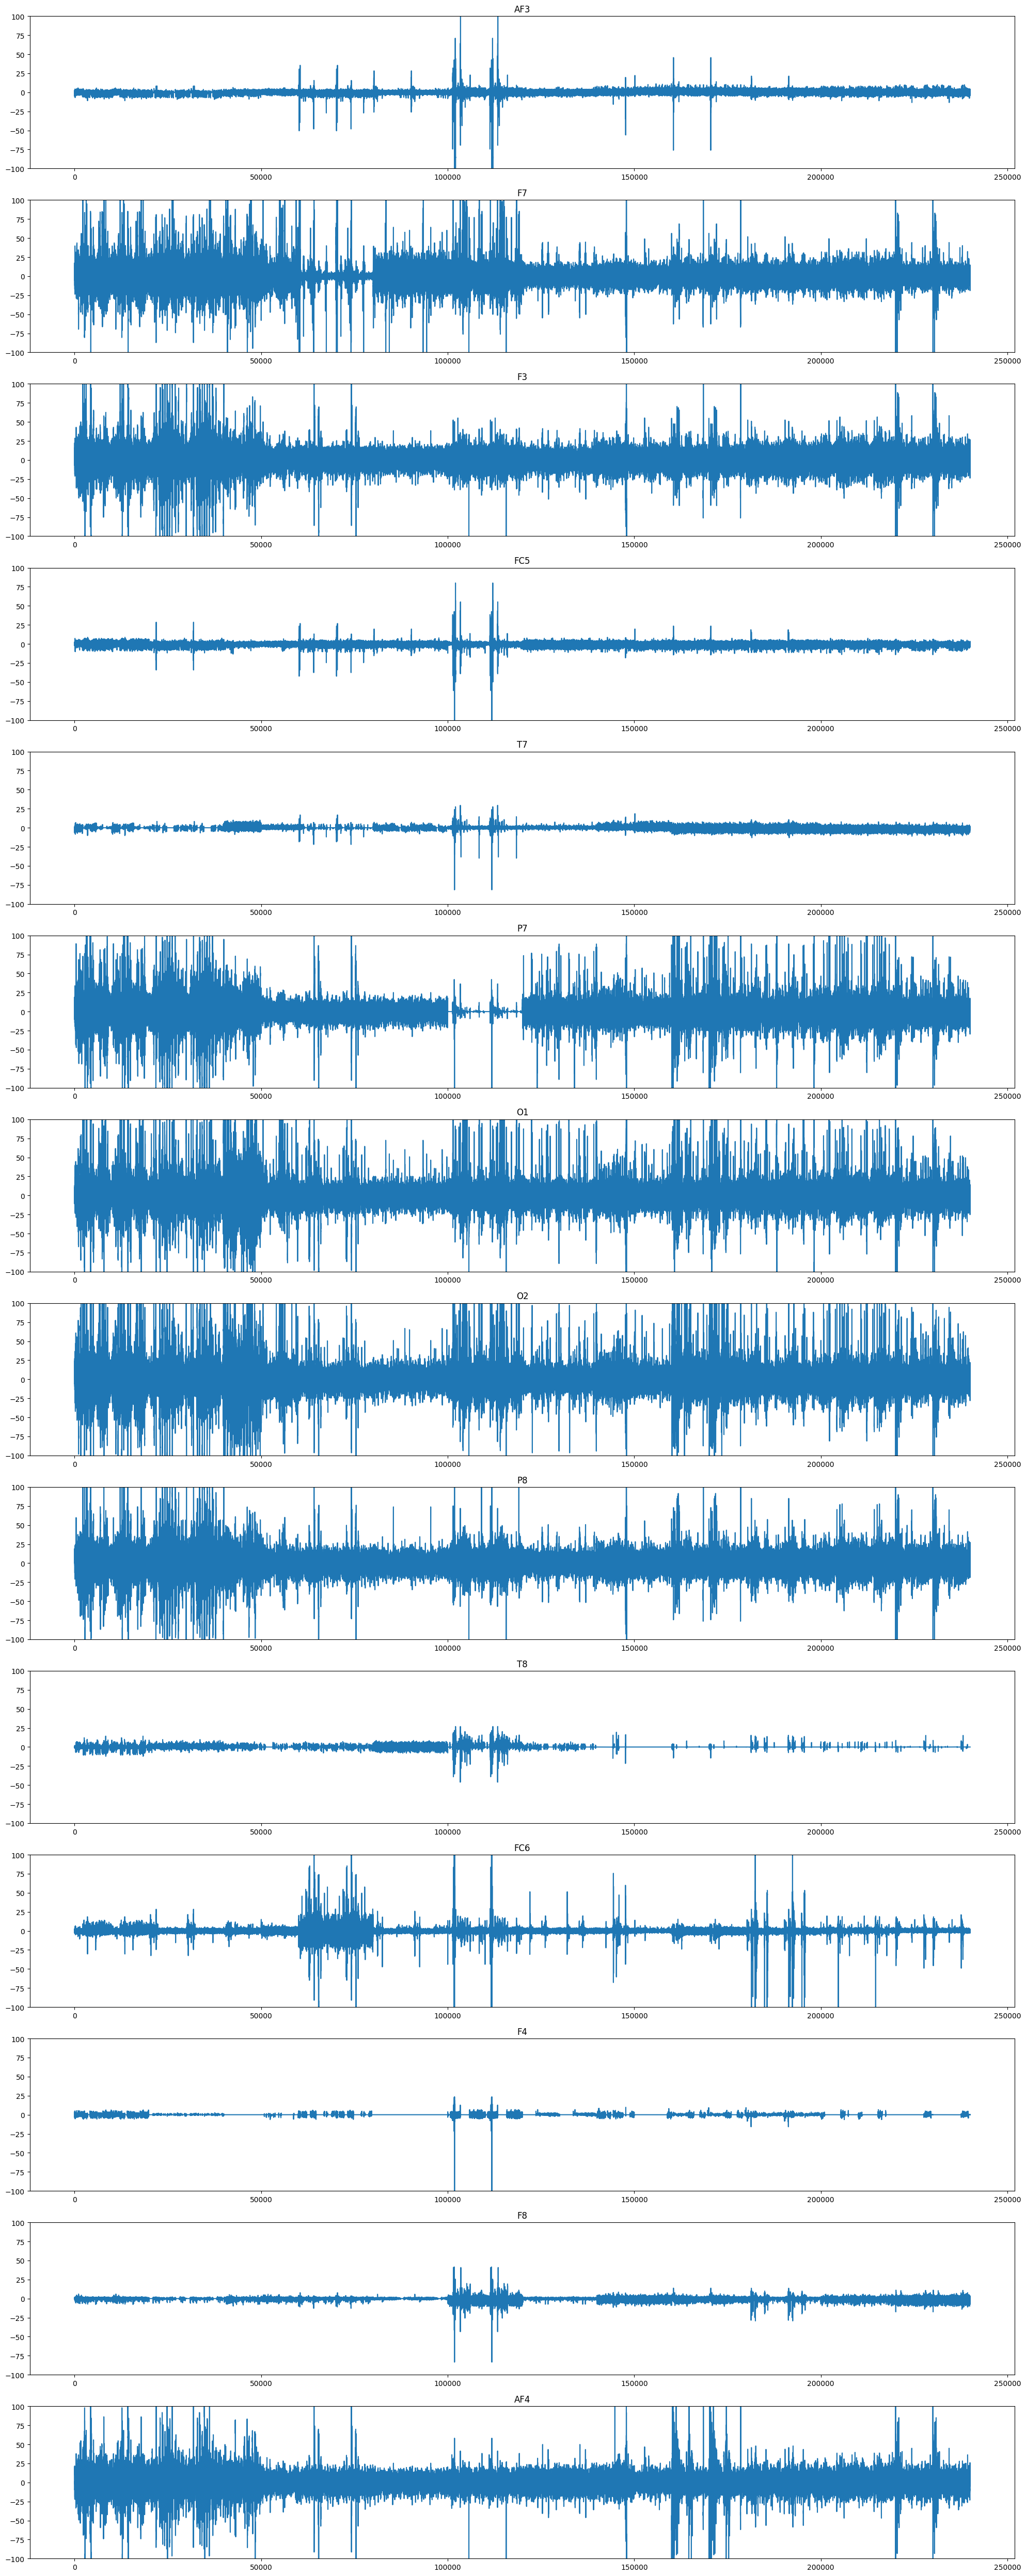

In [148]:
plot_all_channels(filtered_reduce_data, channel_names)

In [149]:
# 'F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4'
useful_channels=[1,2,5,6,7,8,13]
useful_channels_names=['F7','F3','P7','O1','O2','P8','AF4']

filtered_full_data_7channel = [eeg_data[:, useful_channels] for eeg_data in filtered_full_data]
filtered_reduce_data_7channel = get_data_5days(filtered_full_data_7channel)

#### **Visualize data**

In [150]:
def analyze_data(filtered_all_data, file_names, subject_map=None, num_files=2):
    # Phân tích dữ liệu
    if subject_map is not None:
        # Chỉ phân tích những file có trong subject_map
        valid_indices = sum(subject_map.values(), [])
        valid_indices = [x - 1 for x in valid_indices]
    else:
        # Phân tích tất cả các file
        valid_indices = list(range(len(file_names)))

    for i in valid_indices[:num_files]:  # Duyệt qua một số file để trực quan hóa
        data, eeg_data = load_data(file_names[i])

        # Vẽ dữ liệu đầy đủ từ file
        print('Dữ liệu đầy đủ từ file {}:'.format(file_names[i]), data.shape)
        plt.figure(figsize=(10, 4))
        plt.plot(data)
        plt.title(f'Dữ liệu đầy đủ từ File {i + 1}')
        plt.xlabel('Samples')
        plt.ylabel('EEG Signal Amplitude')
        plt.show()

        # Vẽ dữ liệu từ các kênh 4-17
        print('\nDữ liệu EEG từ các kênh 4-17:', eeg_data.shape)
        plt.figure(figsize=(10, 4))
        plt.plot(eeg_data[:1000, :])  # Giả sử vẽ 1000 mẫu đầu tiên
        plt.title('Data EEG (Channel 4-17) from 1000 data')
        plt.xlabel('Samples')
        plt.ylabel('EEG Signal Amplitude')
        plt.show()

        # Biểu diễn tín hiệu sau khi lọc của 1000 data đầu tiên
        filtered_data = filtered_all_data[i]  # Lấy dữ liệu đã lọc của file thứ i
        plt.figure(figsize=(10, 4))
        plt.plot(filtered_data[:1000, :])  # Lấy 1000 mẫu đầu tiên từ dữ liệu đã lọc
        plt.title('EEG Data After Filtering (High-pass, Low-pass, Notch) from 1000 data')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.show()

Dữ liệu đầy đủ từ file C:\Users\Admin\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1\EEG Data\eeg_record1.mat: (308868, 25)


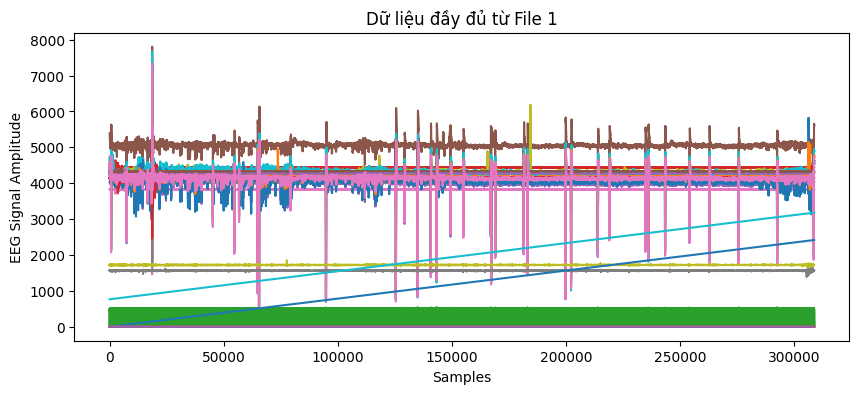


Dữ liệu EEG từ các kênh 4-17: (308868, 14)


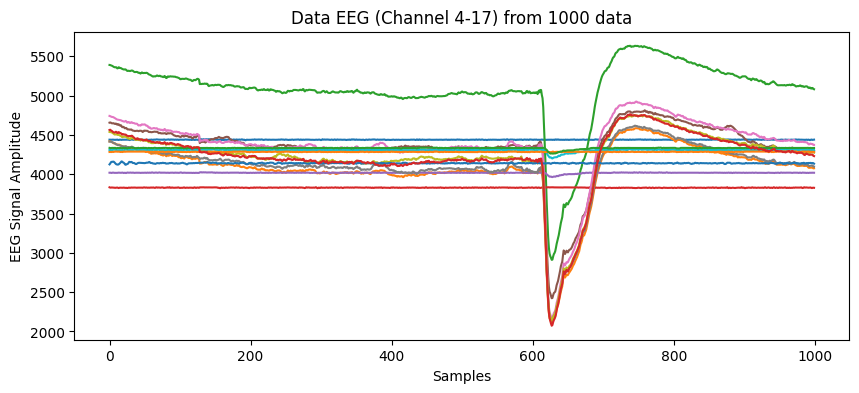

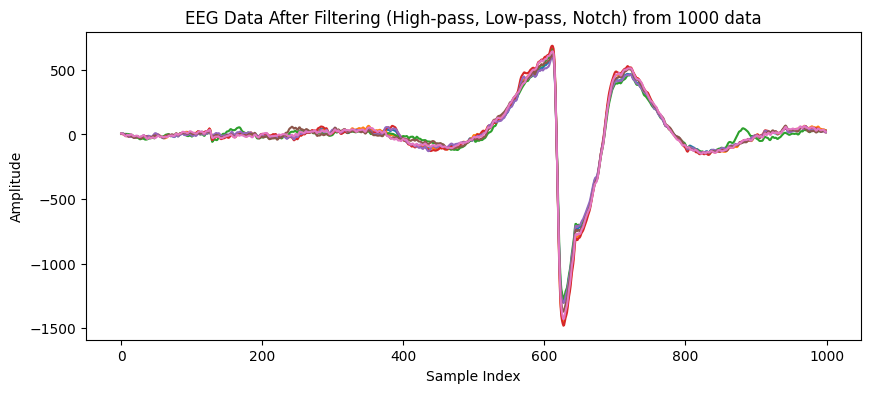

Dữ liệu đầy đủ từ file C:\Users\Admin\.cache\kagglehub\datasets\inancigdem\eeg-data-for-mental-attention-state-detection\versions\1\EEG Data\EEG Data\eeg_record1.mat: (308868, 25)


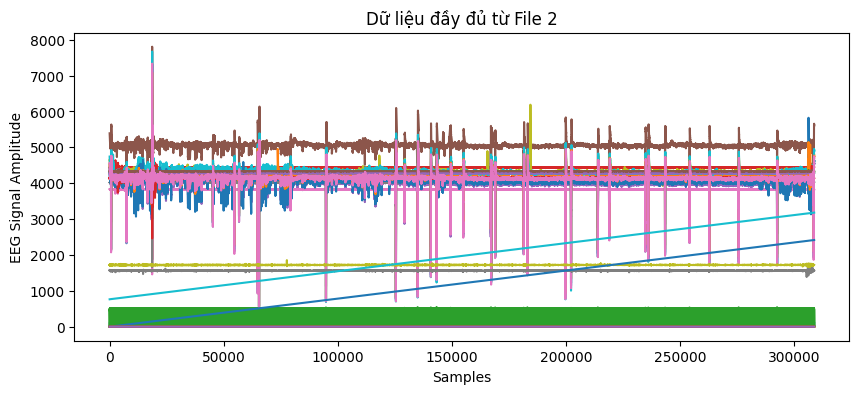


Dữ liệu EEG từ các kênh 4-17: (308868, 14)


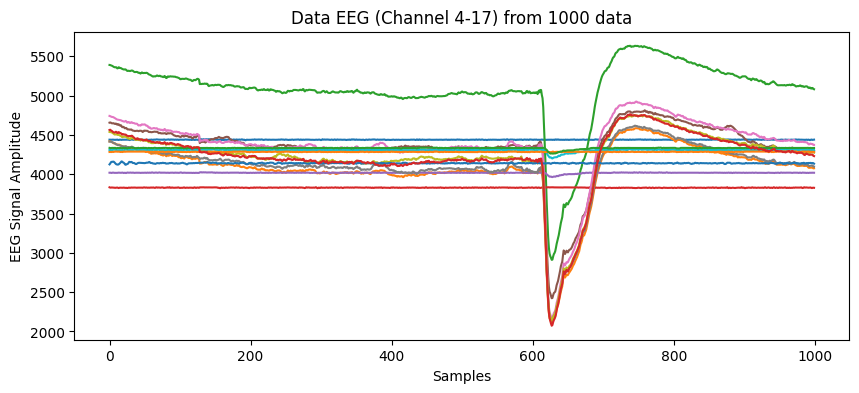

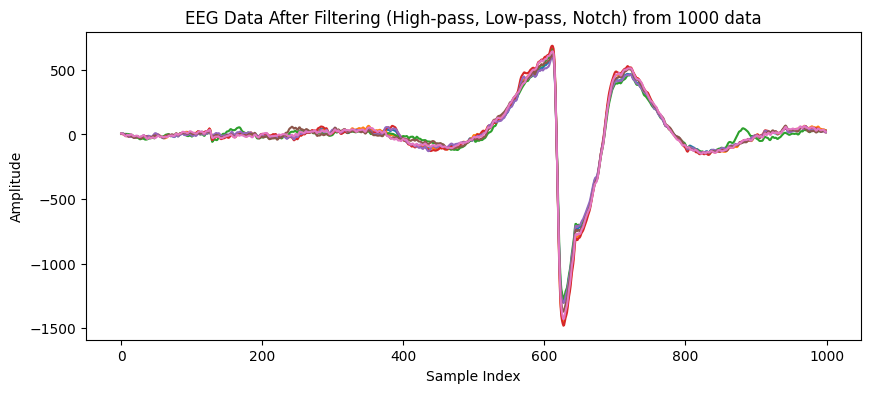

In [151]:
analyze_data(filtered_full_data_7channel, file_names)

#### **Nhận xét các hình ảnh trực quan:**

* Hình ảnh **1** và **4** lần lượt vẽ toàn bộ dữ liệu EEG từ `file 1` và `file 2`. Trục x biểu thị các mẫu dữ liệu, trong khi trục y là biên độ của tín hiệu EEG. Việc quan sát dữ liệu ở dạng thô như vậy giúp chúng ta nhận diện được các nhiễu, mất tín hiệu hoặc các đặc điểm chung của tín hiệu EEG.

* Hình ảnh **2** và **5** vẽ dữ liệu EEG được trích xuất từ các kênh **4-17**, là các kênh quan trọng trong việc phân tích trạng thái chú ý. Việc hiển thị dữ liệu từ nhiều kênh giúp so sánh các đặc điểm tín hiệu của từng kênh, ví dụ như sự thay đổi biên độ hoặc sự khác biệt về mẫu tín hiệu. Điều này rất hữu ích khi chúng ta cần tìm hiểu mối quan hệ giữa các kênh trong dữ liệu EEG.

* Hình ảnh **3** và **6** trực quan hóa tín hiệu EEG sau khi đã áp dụng các bộ lọc như `high-pass`, `low-pass` và `notch filter`. Các bộ lọc này giúp loại bỏ nhiễu không mong muốn, đặc biệt là những tần số nằm ngoài phạm vi quan tâm. Sau khi lọc, tín hiệu sẽ mượt mà hơn, giúp dễ dàng hơn trong việc phân tích và trích xuất đặc trưng, cũng như nâng cao độ chính xác khi phân loại.

In [152]:
# Số tổng subject (5)
total_subjects = 5

# Tạo ánh xạ subject_map, với việc lùi chỉ số
subject_map = {}
for s in range(1, total_subjects + 1):
    # Lùi chỉ số 2 ngày đầu, vì cần bỏ qua 2 ngày thử nghiệm
    a = int(7 * (s - 1)) + 3  # Bắt đầu từ ngày thứ 3
    if s != 5:
        b = a + 5  # Người 1-4 có 5 ngày thực tế
    else:
        b = a + 4  # Người 5 có 4 ngày thực tế
    subject_map[s] = [i for i in range(a, b)]

# In ra subject_map để kiểm tra
print(subject_map)

{1: [3, 4, 5, 6, 7], 2: [10, 11, 12, 13, 14], 3: [17, 18, 19, 20, 21], 4: [24, 25, 26, 27, 28], 5: [31, 32, 33, 34]}


* **Subject 1:** Tham gia từ ngày 3 đến ngày 7 (5 ngày thực tế).

* **Subject 2:** Tham gia từ ngày 10 đến ngày 14 (5 ngày thực tế).

* **Subject 3:** Tham gia từ ngày 17 đến ngày 21 (5 ngày thực tế).

* **Subject 4:** Tham gia từ ngày 24 đến ngày 28 (5 ngày thực tế).

* **Subject 5:** Tham gia từ ngày 31 đến ngày 34 (4 ngày thực tế).

#### **Sơ lược về các dải tần số**

- Dải tần số `Delta` (0.5–4 Hz) thường xuất hiện trong **giấc ngủ sâu** và hỗ trợ **phục hồi cơ thể**. Sóng Delta đặc trưng cho giai đoạn ngủ không mơ (non-REM sleep), khi não bộ tiến hành quá trình tái tạo và phục hồi năng lượng.

- Dải tần số `Theta` (4–8 Hz) liên quan đến sự **thư giãn sâu** và **trạng thái mơ màng**, thường xuất hiện khi cơ thể thư giãn hoặc trong các trạng thái thiền định.

- Dải tần số `Alpha` (8–13 Hz) phản ánh trạng thái **thư giãn nhưng tỉnh táo**, thường xuất hiện khi con người nghỉ ngơi, nhắm mắt hoặc ở trạng thái thư thái, giúp giảm căng thẳng và duy trì sự tỉnh táo nhẹ.

- Dải tần số `Beta` (13–30 Hz) liên quan đến các hoạt động **tập trung cao độ** và **căng thẳng**. Sóng Beta xuất hiện khi chúng ta suy nghĩ, giải quyết vấn đề hoặc trong các trạng thái lo âu, căng thẳng.

Áp dụng các bộ lọc thông dải (`bandpass_filter`) để tách riêng các dải tần số cụ thể (Delta, Theta, Alpha, Beta) và trực quan hoá chúng trên 1000 samples đầu tiên.

In [153]:
def plot_frequency_bands(filtered_data):
    # Định nghĩa các dải tần số
    alpha_low, alpha_high = 8, 13  # Hz
    beta_low, beta_high = 13, 30  # Hz
    delta_low, delta_high = 0.5, 4  # Hz
    theta_low, theta_high = 4, 8  # Hz

    # Lọc thông dải để giữ lại các dải tần số khác nhau
    alpha_band = bandpass_filter(filtered_data, alpha_low, alpha_high, sampFreq)
    beta_band = bandpass_filter(filtered_data, beta_low, beta_high, sampFreq)
    delta_band = bandpass_filter(filtered_data, delta_low, delta_high, sampFreq)
    theta_band = bandpass_filter(filtered_data, theta_low, theta_high, sampFreq)

    # Biểu diễn tín hiệu dải delta
    plt.figure(figsize=(15, 6))
    plt.plot(delta_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
    plt.title('EEG Delta Band (0.5-4 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Biểu diễn tín hiệu dải theta
    plt.figure(figsize=(15, 6))
    plt.plot(theta_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
    plt.title('EEG Theta Band (4-8 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Biểu diễn tín hiệu dải alpha
    plt.figure(figsize=(15, 6))
    plt.plot(alpha_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
    plt.title('EEG Alpha Band (8-13 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Biểu diễn tín hiệu dải beta
    plt.figure(figsize=(15, 6))
    plt.plot(beta_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
    plt.title('EEG Beta Band (13-30 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()


**Trực quan hóa các dải tần số Delta, Theta, Alpha và Beta trên dữ liệu EEG (lấy 7 ngày thử nghiệm) đã được lọc bằng các bộ lọc**

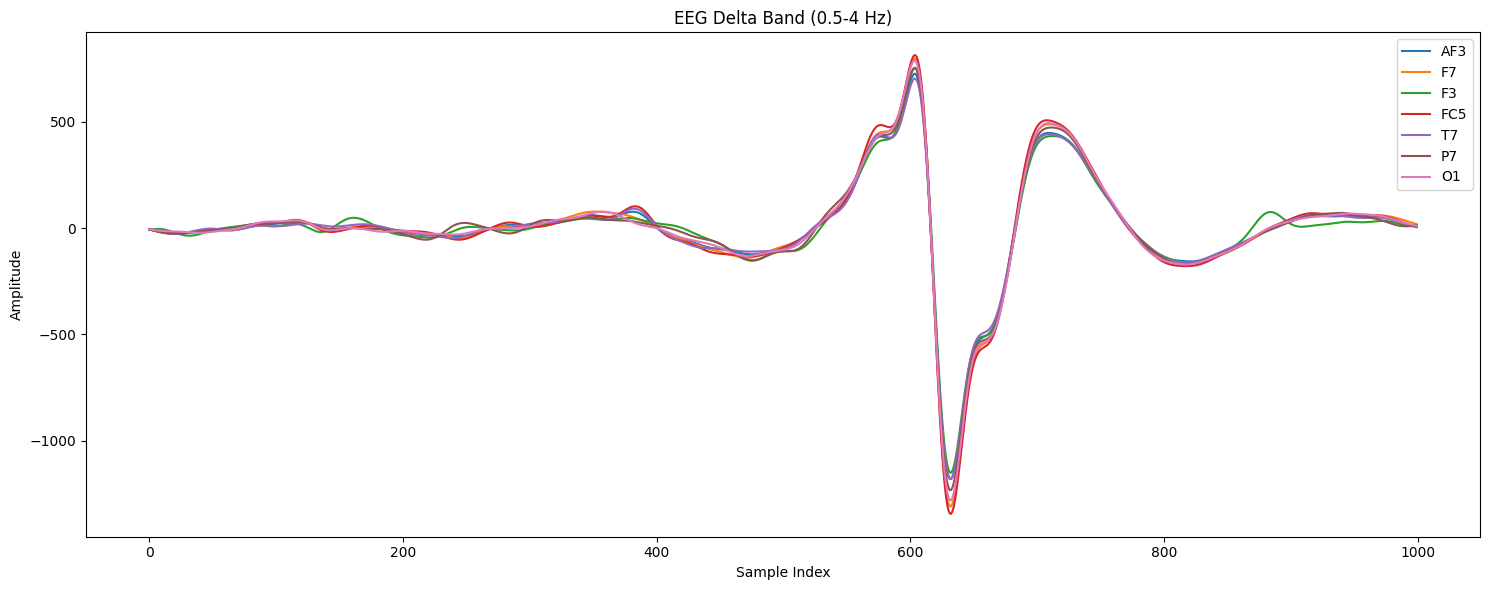

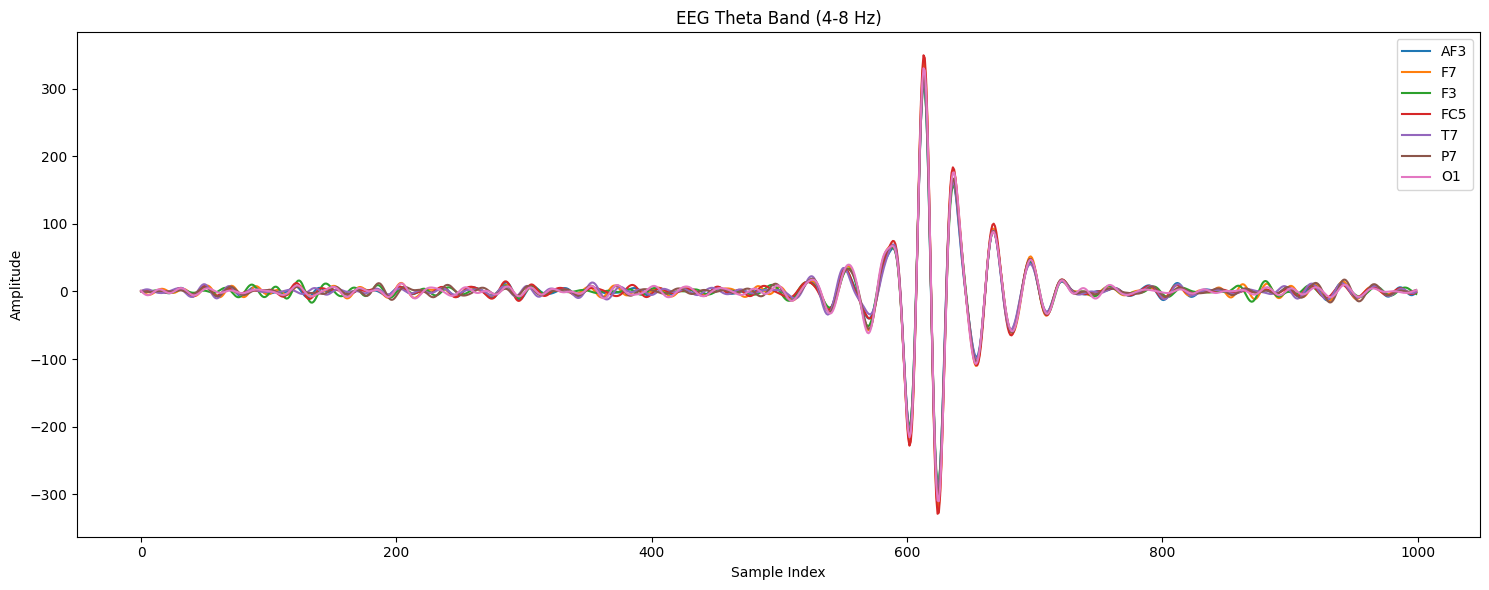

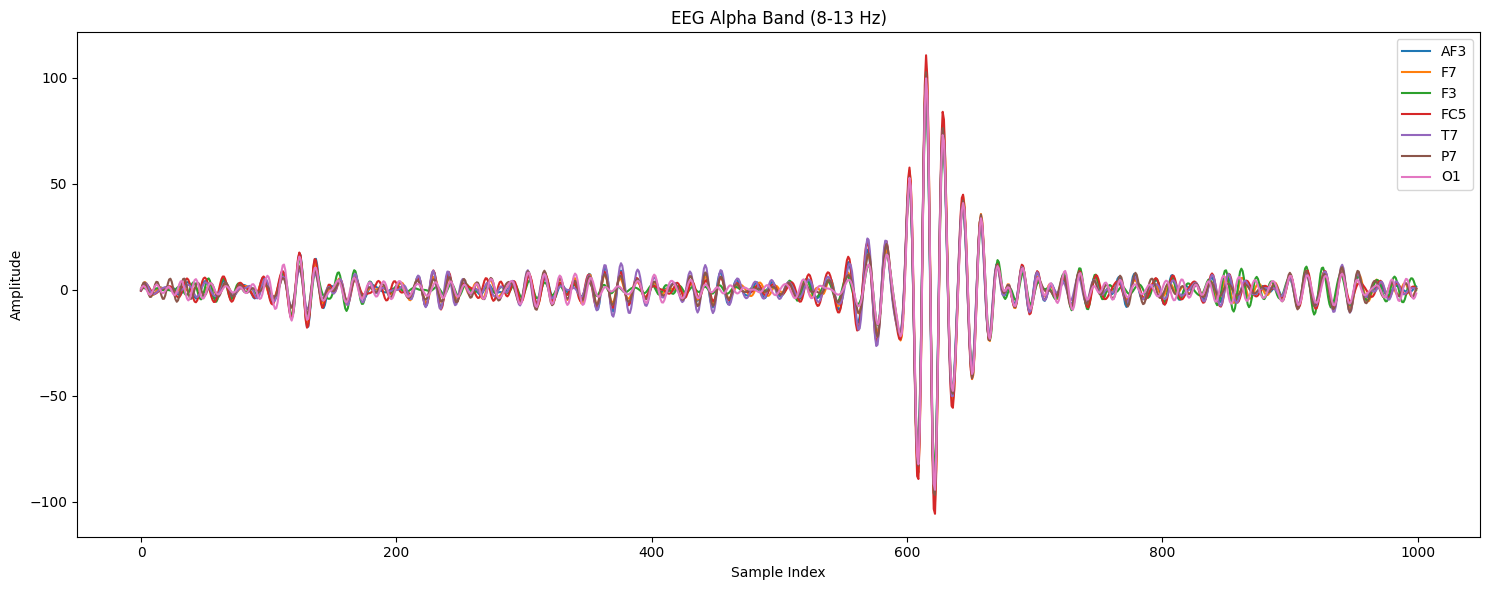

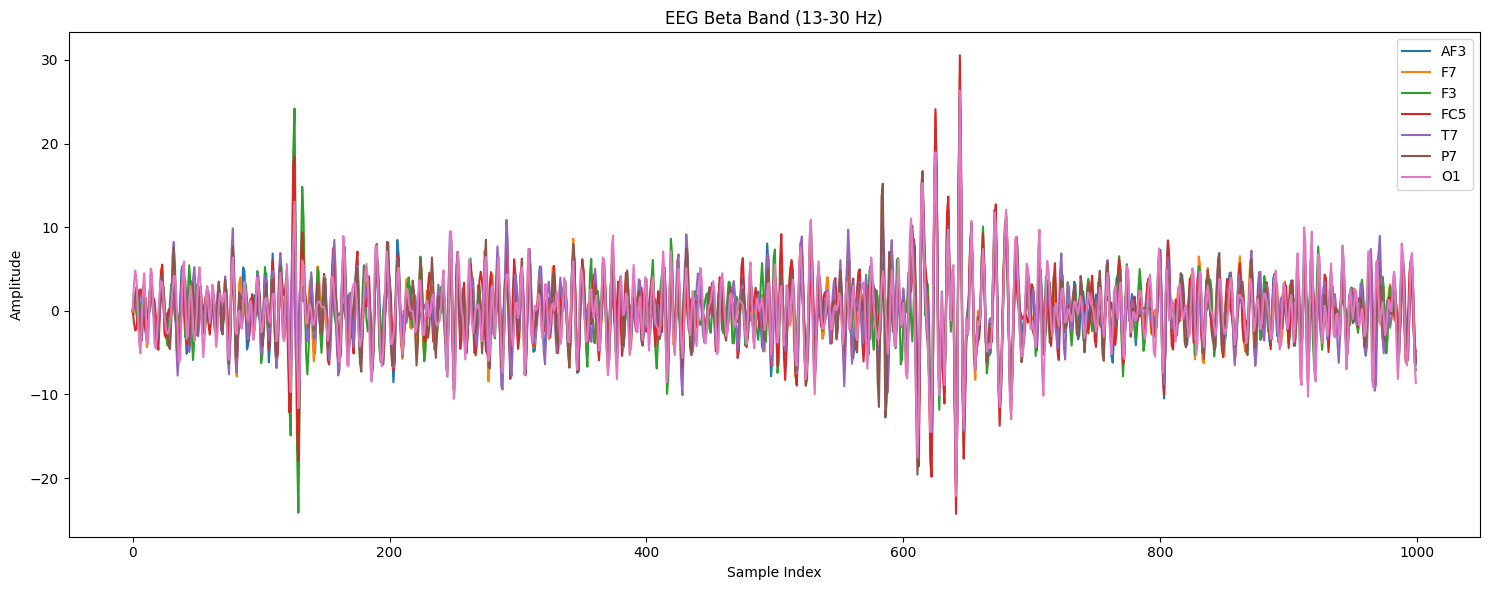

In [154]:
plot_frequency_bands(filtered_full_data_7channel[0])

**Trực quan hóa các dải tần số Delta, Theta, Alpha và Beta trên dữ liệu EEG (lấy 5 ngày thử nghiệm sau) đã được lọc bằng các bộ lọc**

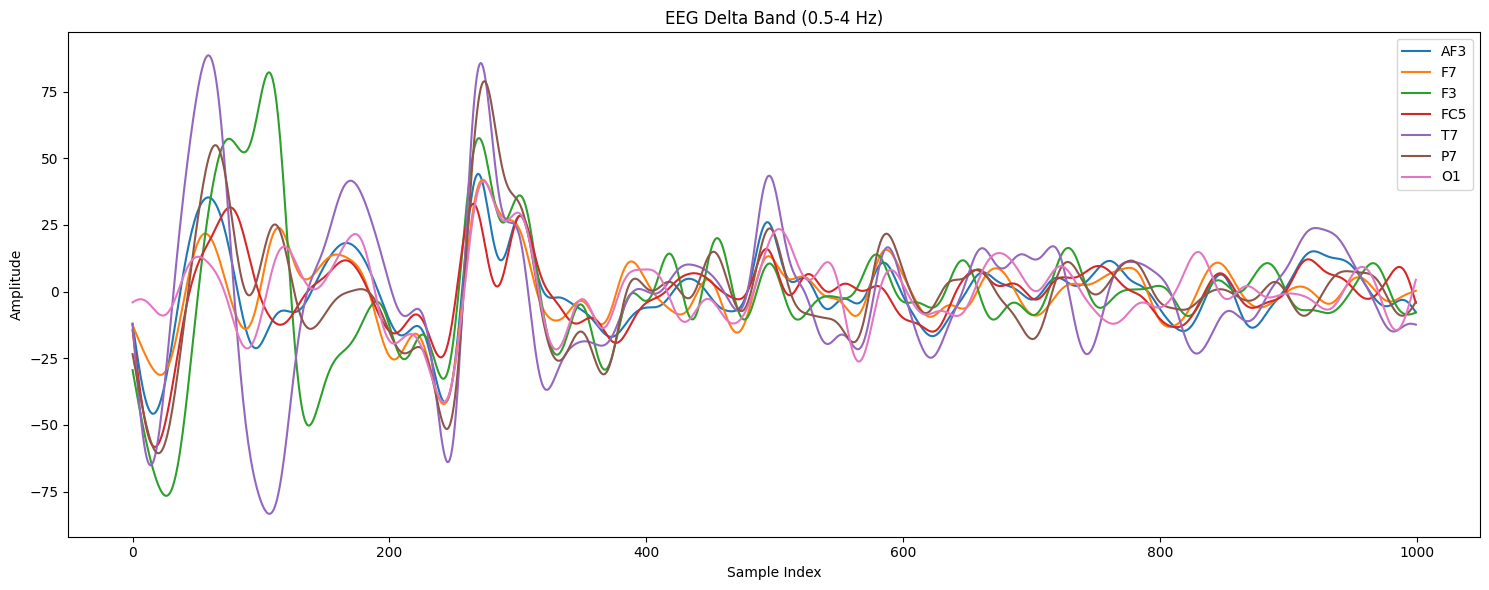

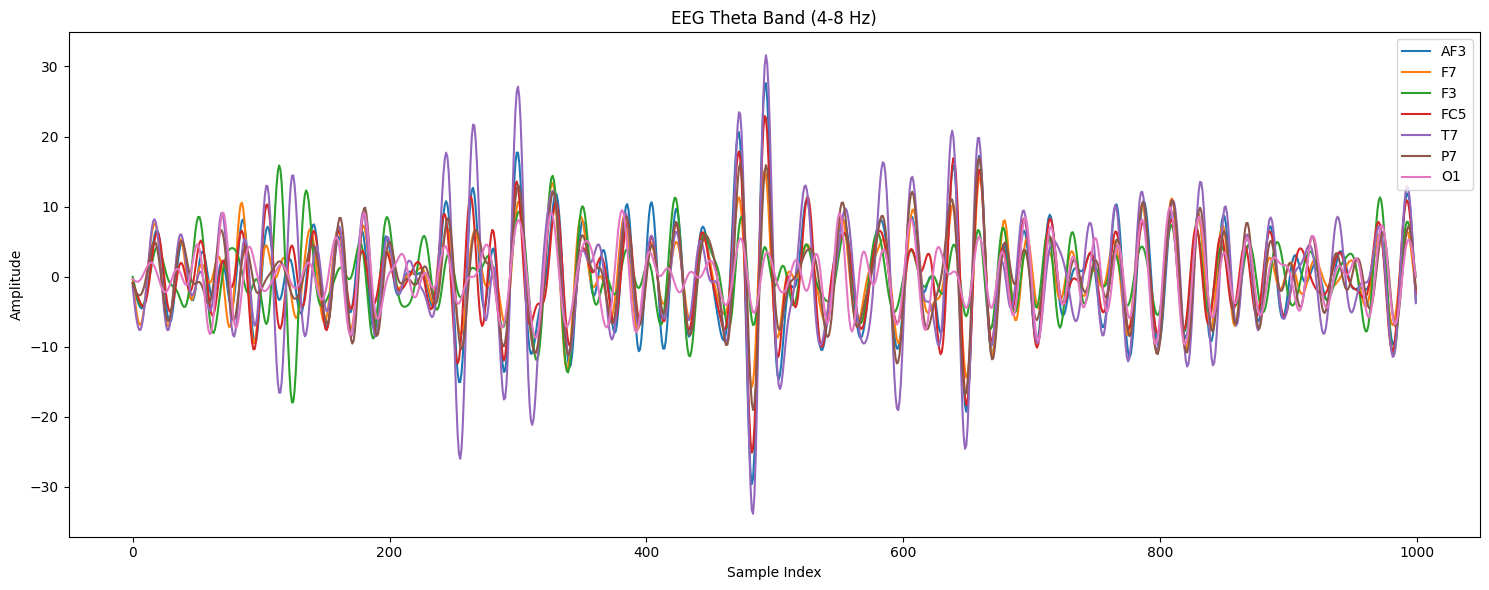

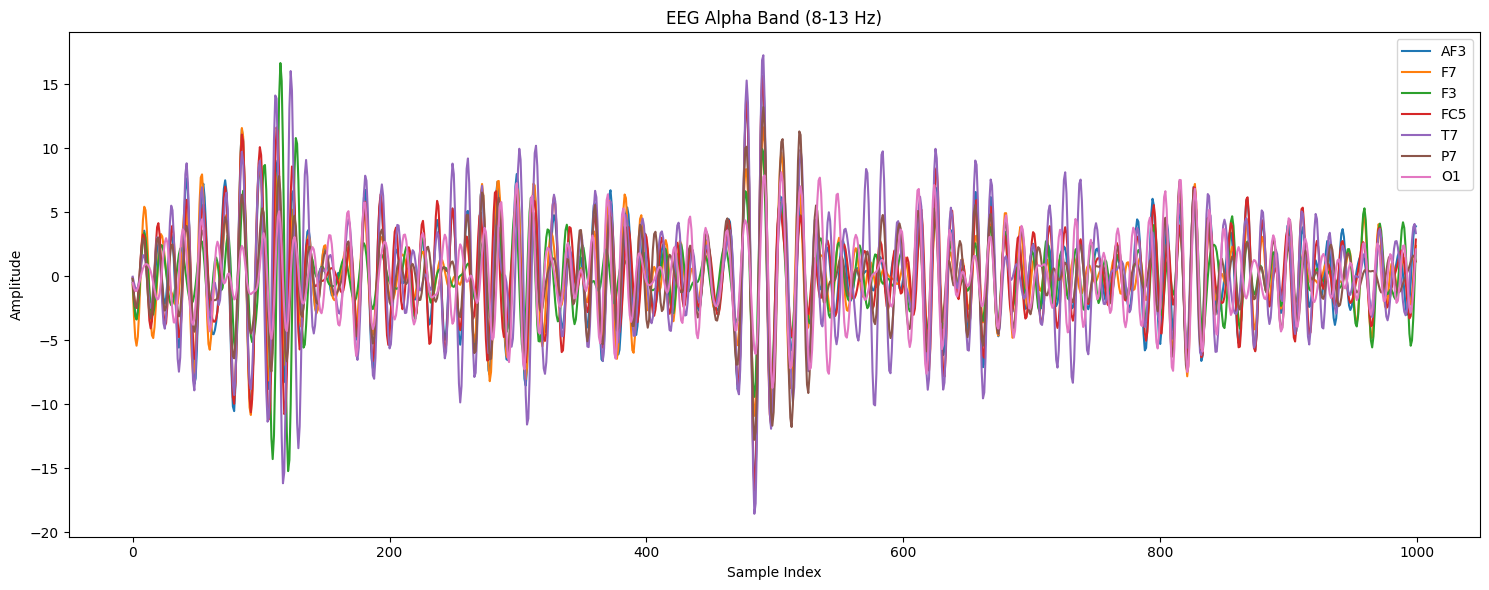

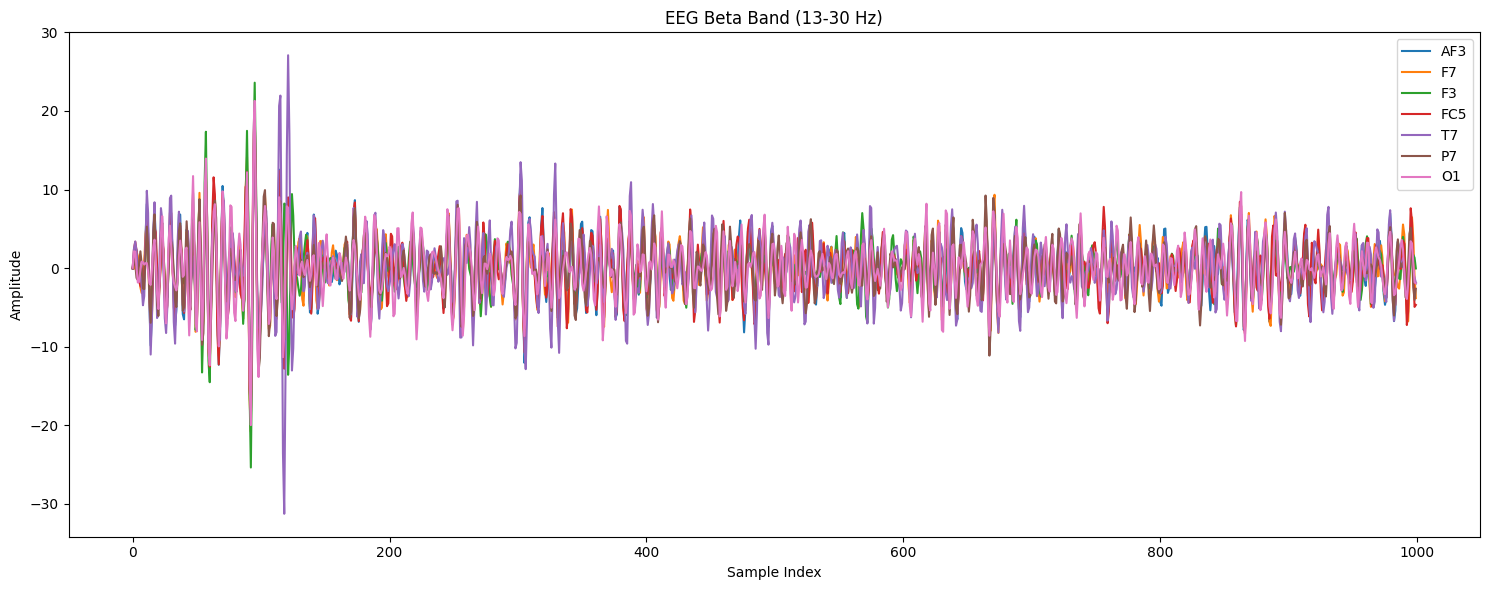

In [155]:
plot_frequency_bands(filtered_reduce_data_7channel[0])

### **Independent Component Analysis (ICA)**

ICA là một phương pháp mạnh mẽ để tách các thành phần tín hiệu độc lập từ dữ liệu hỗn hợp. Trong bối cảnh EEG, tín hiệu thu được thường là sự kết hợp của nhiều nguồn tín hiệu, bao gồm cả nhiễu cơ học (chẳng hạn như chuyển động mắt EOG), nhiễu điện tim ECG, và tín hiệu não. ICA giúp phân tách các thành phần này, cho phép loại bỏ các nhiễu không liên quan và chỉ giữ lại các thành phần liên quan đến hoạt động não.

##### **Montage trong EEG là gì?**

- Montage trong EEG là cách các kênh điện cực được sắp xếp trên đầu của một người tham gia nghiên cứu. Nó quyết định vị trí mà các điện cực được đặt trên da đầu, từ đó ảnh hưởng đến cách tín hiệu được ghi lại và phân tích.

##### **Lưới montage 10-20 là gì?**
- Lưới montage 10-20 là một hệ thống sắp xếp tiêu chuẩn được sử dụng để gắn các điện cực lên đầu người tham gia nghiên cứu. Nó được gọi là "10-20" vì khoảng cách giữa các điện cực trong lưới này bằng 10% hoặc 20% của vòng đầu của người tham gia.

    - 10% và 20%: Độ dài của chu vi đầu người được chia thành các đoạn tương ứng 10% và 20%, và các điện cực được đặt tại những vị trí này.
    
    - Hệ thống này có tính nhất quán: Dù người tham gia có kích thước đầu khác nhau, hệ thống này vẫn giúp việc gắn điện cực được thực hiện một cách có hệ thống và dễ dàng tái tạo.

##### **Lý do sử dụng montage 10-20 trong xử lý EEG**

Montage 10-20 là hệ thống chuẩn để gắn các điện cực EEG lên đầu người tham gia nghiên cứu. Việc sử dụng montage này trong xử lý EEG có các lý do quan trọng:

1. **Xác định vị trí chính xác của các kênh**: Gán montage vào đối tượng `Raw` trong MNE giúp xác định chính xác vị trí của các tín hiệu từ các điện cực.

2. **Chuẩn hóa và tái tạo nghiên cứu**: Hệ thống 10-20 cung cấp một chuẩn mực chung, giúp so sánh kết quả nghiên cứu và đảm bảo tính nhất quán trong các phân tích EEG.

3. **Định vị các khu vực chức năng của não**: Montage giúp phân tích tín hiệu theo các vùng chức năng như:
   - **Frontal (trán)**: Nhận thức và hành vi.
   
   - **Central (đỉnh đầu)**: Cảm giác và vận động.
   
   - **Occipital (sau gáy)**: Xử lý thị giác.

Việc gán montage giúp xác định chính xác nguồn gốc tín hiệu và hỗ trợ phân tích dựa trên các vùng chức năng của não.

In [156]:
import mne
from mne.preprocessing import ICA

def apply_ica_to_data(filtered_data):
    ica_list = []
    raw_list = []

    for i in range(len(filtered_data)):

        data_one_day = filtered_data[i]

        # Tạo thông tin cho đối tượng Raw
        sfreq = 128  # Tần số lấy mẫu (giả sử là 128 Hz, bạn có thể thay đổi nếu khác)
        info = mne.create_info(ch_names=useful_channels_names, sfreq=sfreq, ch_types='eeg')

        # Lấy dữ liệu đã lọc từ danh sách, chuyển đổi thành dạng phù hợp cho MNE
        filtered_data_mne = data_one_day.T  # Chuyển thành (n_channels, n_times)

        # Tạo đối tượng Raw từ dữ liệu
        raw = mne.io.RawArray(filtered_data_mne, info)

        # Thêm montage vào đối tượng Raw với montage 'standard_1020'
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)

        # Áp dụng ICA để tách các thành phần độc lập
        ica = ICA(n_components=7, random_state=42, max_iter='auto')
        ica.fit(raw)

        # Lưu ICA và Raw để sử dụng sau
        ica_list.append(ica)
        raw_list.append(raw)

        # In ra thông báo đã xử lý xong
        print(f'Đã áp dụng ICA cho dữ liệu của người thứ {i+1}')

    return ica_list, raw_list

In [157]:
# Áp dụng hàm cho filtered_full_data và filtered_reduce_data
ica_full_data, raw_full_data = apply_ica_to_data(filtered_full_data_7channel)

ica_reduce_data = get_data_5days(ica_full_data)
raw_reduce_data = get_data_5days(raw_full_data)

Creating RawArray with float64 data, n_channels=7, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 1
Creating RawArray with float64 data, n_channels=7, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 2
Creating RawArray with float64 data, n_channels=7, n_times=366020
    Range : 0 ... 366019 =      0.000 ...  2859.523 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 3
Creating RawArray with float64 data, n_channels=7, n_times=366020
    Range : 0 ... 366019 =      0.000 ...  2859.523 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 4
Creating RawArray with float64 data, n_channels=7, n_times=357224
    Range : 0 ... 357223 =      0.000 ...  2790.805 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 5
Creating RawArray with float64 data, n_channels=7, n_times=357224
    Range : 0 ... 357223 =      0.000 ...  2790.805 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 6
Creating RawArray with float64 data, n_channels=7, n_times=380344
    Range : 0 ... 380343 =      0.000 ...  2971.430 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 6.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 7
Creating RawArray with float64 data, n_channels=7, n_times=380344
    Range : 0 ... 380343 =      0.000 ...  2971.430 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 6.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 8
Creating RawArray with float64 data, n_channels=7, n_times=351204
    Range : 0 ... 351203 =      0.000 ...  2743.773 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 8.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 9
Creating RawArray with float64 data, n_channels=7, n_times=351204
    Range : 0 ... 351203 =      0.000 ...  2743.773 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 8.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 10
Creating RawArray with float64 data, n_channels=7, n_times=288752
    Range : 0 ... 288751 =      0.000 ...  2255.867 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 4.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 11
Creating RawArray with float64 data, n_channels=7, n_times=288752
    Range : 0 ... 288751 =      0.000 ...  2255.867 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 4.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 12
Creating RawArray with float64 data, n_channels=7, n_times=398816
    Range : 0 ... 398815 =      0.000 ...  3115.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 13
Creating RawArray with float64 data, n_channels=7, n_times=398816
    Range : 0 ... 398815 =      0.000 ...  3115.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 14
Creating RawArray with float64 data, n_channels=7, n_times=365888
    Range : 0 ... 365887 =      0.000 ...  2858.492 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 4.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 15
Creating RawArray with float64 data, n_channels=7, n_times=365888
    Range : 0 ... 365887 =      0.000 ...  2858.492 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 4.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 16
Creating RawArray with float64 data, n_channels=7, n_times=388788
    Range : 0 ... 388787 =      0.000 ...  3037.398 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 17
Creating RawArray with float64 data, n_channels=7, n_times=388788
    Range : 0 ... 388787 =      0.000 ...  3037.398 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 18
Creating RawArray with float64 data, n_channels=7, n_times=381340
    Range : 0 ... 381339 =      0.000 ...  2979.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 6.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 19
Creating RawArray with float64 data, n_channels=7, n_times=381340
    Range : 0 ... 381339 =      0.000 ...  2979.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 7.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 20
Creating RawArray with float64 data, n_channels=7, n_times=391624
    Range : 0 ... 391623 =      0.000 ...  3059.555 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 4.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 21
Creating RawArray with float64 data, n_channels=7, n_times=391624
    Range : 0 ... 391623 =      0.000 ...  3059.555 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 22
Creating RawArray with float64 data, n_channels=7, n_times=356728
    Range : 0 ... 356727 =      0.000 ...  2786.930 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 6.0s.
Đã áp dụng ICA cho dữ liệu của người thứ 23
Creating RawArray with float64 data, n_channels=7, n_times=356728
    Range : 0 ... 356727 =      0.000 ...  2786.930 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 5.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 24
Creating RawArray with float64 data, n_channels=7, n_times=373304
    Range : 0 ... 373303 =      0.000 ...  2916.430 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 25
Creating RawArray with float64 data, n_channels=7, n_times=373304
    Range : 0 ... 373303 =      0.000 ...  2916.430 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 26
Creating RawArray with float64 data, n_channels=7, n_times=345164
    Range : 0 ... 345163 =      0.000 ...  2696.586 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 27
Creating RawArray with float64 data, n_channels=7, n_times=345164
    Range : 0 ... 345163 =      0.000 ...  2696.586 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 28
Creating RawArray with float64 data, n_channels=7, n_times=359164
    Range : 0 ... 359163 =      0.000 ...  2805.961 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 29
Creating RawArray with float64 data, n_channels=7, n_times=359164
    Range : 0 ... 359163 =      0.000 ...  2805.961 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.5s.
Đã áp dụng ICA cho dữ liệu của người thứ 30
Creating RawArray with float64 data, n_channels=7, n_times=234372
    Range : 0 ... 234371 =      0.000 ...  1831.023 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 31
Creating RawArray with float64 data, n_channels=7, n_times=234372
    Range : 0 ... 234371 =      0.000 ...  1831.023 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 32
Creating RawArray with float64 data, n_channels=7, n_times=443972
    Range : 0 ... 443971 =      0.000 ...  3468.523 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 5.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 33
Creating RawArray with float64 data, n_channels=7, n_times=443972
    Range : 0 ... 443971 =      0.000 ...  3468.523 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 5.5s.
Đã áp dụng ICA cho dữ liệu của người thứ 34
Creating RawArray with float64 data, n_channels=7, n_times=361840
    Range : 0 ... 361839 =      0.000 ...  2826.867 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 6.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 35
Creating RawArray with float64 data, n_channels=7, n_times=361840
    Range : 0 ... 361839 =      0.000 ...  2826.867 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 6.0s.
Đã áp dụng ICA cho dữ liệu của người thứ 36
Creating RawArray with float64 data, n_channels=7, n_times=333236
    Range : 0 ... 333235 =      0.000 ...  2603.398 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 37
Creating RawArray with float64 data, n_channels=7, n_times=333236
    Range : 0 ... 333235 =      0.000 ...  2603.398 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 3.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 38
Creating RawArray with float64 data, n_channels=7, n_times=396812
    Range : 0 ... 396811 =      0.000 ...  3100.086 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 39
Creating RawArray with float64 data, n_channels=7, n_times=396812
    Range : 0 ... 396811 =      0.000 ...  3100.086 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.5s.
Đã áp dụng ICA cho dữ liệu của người thứ 40
Creating RawArray with float64 data, n_channels=7, n_times=336280
    Range : 0 ... 336279 =      0.000 ...  2627.180 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 41
Creating RawArray with float64 data, n_channels=7, n_times=336280
    Range : 0 ... 336279 =      0.000 ...  2627.180 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 42
Creating RawArray with float64 data, n_channels=7, n_times=324764
    Range : 0 ... 324763 =      0.000 ...  2537.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 7.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 43
Creating RawArray with float64 data, n_channels=7, n_times=324764
    Range : 0 ... 324763 =      0.000 ...  2537.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 7.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 44
Creating RawArray with float64 data, n_channels=7, n_times=388088
    Range : 0 ... 388087 =      0.000 ...  3031.930 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 10.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 45
Creating RawArray with float64 data, n_channels=7, n_times=388088
    Range : 0 ... 388087 =      0.000 ...  3031.930 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 10.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 46
Creating RawArray with float64 data, n_channels=7, n_times=360928
    Range : 0 ... 360927 =      0.000 ...  2819.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 5.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 47
Creating RawArray with float64 data, n_channels=7, n_times=360928
    Range : 0 ... 360927 =      0.000 ...  2819.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 5.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 48
Creating RawArray with float64 data, n_channels=7, n_times=415164
    Range : 0 ... 415163 =      0.000 ...  3243.461 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 5.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 49
Creating RawArray with float64 data, n_channels=7, n_times=415164
    Range : 0 ... 415163 =      0.000 ...  3243.461 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 5.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 50
Creating RawArray with float64 data, n_channels=7, n_times=363232
    Range : 0 ... 363231 =      0.000 ...  2837.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 4.5s.
Đã áp dụng ICA cho dữ liệu của người thứ 51
Creating RawArray with float64 data, n_channels=7, n_times=363232
    Range : 0 ... 363231 =      0.000 ...  2837.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 4.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 52
Creating RawArray with float64 data, n_channels=7, n_times=347548
    Range : 0 ... 347547 =      0.000 ...  2715.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 3.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 53
Creating RawArray with float64 data, n_channels=7, n_times=347548
    Range : 0 ... 347547 =      0.000 ...  2715.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 4.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 54
Creating RawArray with float64 data, n_channels=7, n_times=214540
    Range : 0 ... 214539 =      0.000 ...  1676.086 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 7.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 55
Creating RawArray with float64 data, n_channels=7, n_times=214540
    Range : 0 ... 214539 =      0.000 ...  1676.086 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 5.5s.
Đã áp dụng ICA cho dữ liệu của người thứ 56
Creating RawArray with float64 data, n_channels=7, n_times=424608
    Range : 0 ... 424607 =      0.000 ...  3317.242 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 4.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 57
Creating RawArray with float64 data, n_channels=7, n_times=424608
    Range : 0 ... 424607 =      0.000 ...  3317.242 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 5.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 58
Creating RawArray with float64 data, n_channels=7, n_times=349008
    Range : 0 ... 349007 =      0.000 ...  2726.617 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.0s.
Đã áp dụng ICA cho dữ liệu của người thứ 59
Creating RawArray with float64 data, n_channels=7, n_times=349008
    Range : 0 ... 349007 =      0.000 ...  2726.617 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 2.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 60
Creating RawArray with float64 data, n_channels=7, n_times=428848
    Range : 0 ... 428847 =      0.000 ...  3350.367 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 6.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 61
Creating RawArray with float64 data, n_channels=7, n_times=428848
    Range : 0 ... 428847 =      0.000 ...  3350.367 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 7.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 62
Creating RawArray with float64 data, n_channels=7, n_times=483732
    Range : 0 ... 483731 =      0.000 ...  3779.148 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 6.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 63
Creating RawArray with float64 data, n_channels=7, n_times=483732
    Range : 0 ... 483731 =      0.000 ...  3779.148 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 8.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 64
Creating RawArray with float64 data, n_channels=7, n_times=483376
    Range : 0 ... 483375 =      0.000 ...  3776.367 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 7.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 65
Creating RawArray with float64 data, n_channels=7, n_times=483376
    Range : 0 ... 483375 =      0.000 ...  3776.367 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 7.5s.
Đã áp dụng ICA cho dữ liệu của người thứ 66
Creating RawArray with float64 data, n_channels=7, n_times=408976
    Range : 0 ... 408975 =      0.000 ...  3195.117 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 5.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 67
Creating RawArray with float64 data, n_channels=7, n_times=408976
    Range : 0 ... 408975 =      0.000 ...  3195.117 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 5.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 68


Hàm vẽ các thành phần ICA (được tính từ các đối tượng ICA đã áp dụng vào dữ liệu EEG) cho một số lượng file nhất định, và hiển thị tín hiệu của các thành phần này khi áp dụng lên dữ liệu gốc (Raw data).

In [158]:
def plot_ica_components(ica_list, raw_list, num_files=2, reduce=False):
    # Nếu giảm dữ liệu, tính toán chỉ số file bắt đầu từ file thứ 3
    if reduce:
        start_index = 2  # Người thứ 1 bắt đầu từ file thứ 3
        step = 7  # Bước nhảy mỗi lần là 7 (người 2 từ file thứ 10, người 3 từ file thứ 17, v.v.)
    else:
        start_index = 0  # Nếu không giảm, bắt đầu từ file thứ 1
        step = 1  # Bước nhảy 1 file mỗi lần

    for i in range(num_files):
        # Tính chỉ số file dựa trên người và kiểu dữ liệu
        file_index = start_index + i * step
        if file_index < len(ica_list):
            print(f'Vẽ các thành phần ICA cho file thứ {file_index + 1}')

            # Vẽ các thành phần ICA
            ica_list[file_index].plot_components()

            # Vẽ tín hiệu của các thành phần ICA với Raw data
            ica_list[file_index].plot_sources(raw_list[file_index], start=0, stop=40, show_scrollbars=False)

            plt.show()

**Biểu đồ topomap của các thành phần ICA sau khi tách từ dữ liệu EEG (trực quan hóa cho từng người). Mỗi thành phần ICA được biểu diễn trên một bản đồ, thể hiện sự phân bố không gian của nó trên da đầu.**

* *Mỗi hình tròn trong biểu đồ* đại diện cho một thành phần độc lập (ICA000, ICA001, ..., ICA013), phản ánh quá trình phân tách tín hiệu EEG thành các thành phần riêng biệt. Kỹ thuật ICA giúp tách biệt các nguồn tín hiệu khác nhau, chẳng hạn như hoạt động não bộ và nhiễu từ chuyển động mắt hay cơ.

* *Màu sắc trên bản đồ topomap*
    - Màu đỏ và xanh dương thể hiện biên độ dương và âm của tín hiệu. Các khu vực đỏ chỉ ra sự tăng cường tín hiệu, trong khi màu xanh dương cho thấy sự giảm biên độ.  

    - Các đường đồng mức trên bản đồ biểu thị sự thay đổi cường độ tín hiệu, giúp trực quan hóa sự phân bố không gian của tín hiệu trên da đầu.

* *Phân bố không gian của các thành phần ICA* 
    - Bản đồ topomap mô tả cách mỗi thành phần ICA phân bổ trên bề mặt da đầu, từ đó giúp xác định xem thành phần đó có liên quan đến loại nhiễu nào (ví dụ: chuyển động mắt, nhiễu cơ) hay không.  

    Ví dụ:  
    
    - Một thành phần có cường độ mạnh ở vùng trán có thể liên quan đến các tác động từ chuyển động mắt hoặc nháy mắt.  

    - Các thành phần khác có thể đại diện cho nhiễu từ cơ hoặc tín hiệu não bộ thực sự. 

Sự phân tích này không chỉ giúp nhận diện các nhiễu trong tín hiệu EEG mà còn tạo ra những cái nhìn rõ ràng hơn về hoạt động não bộ trong quá trình thu thập dữ liệu.


Vẽ các thành phần ICA cho file thứ 1


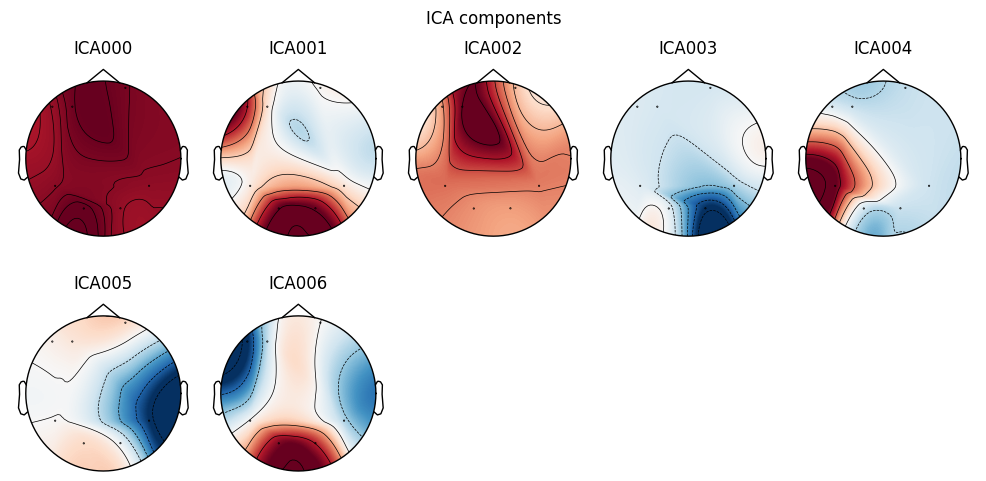

Creating RawArray with float64 data, n_channels=7, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.
Using matplotlib as 2D backend.


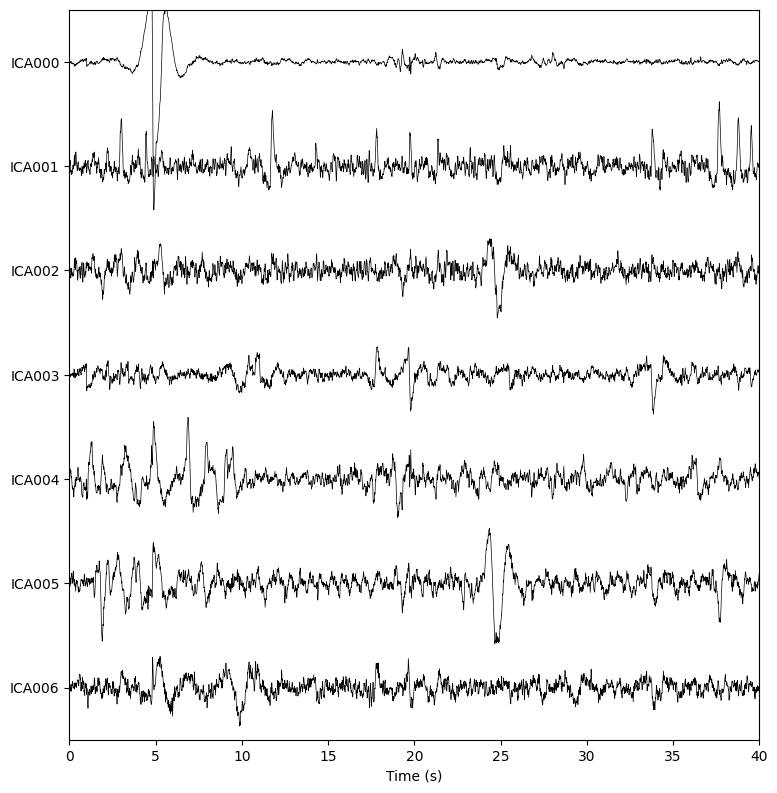

Vẽ các thành phần ICA cho file thứ 2


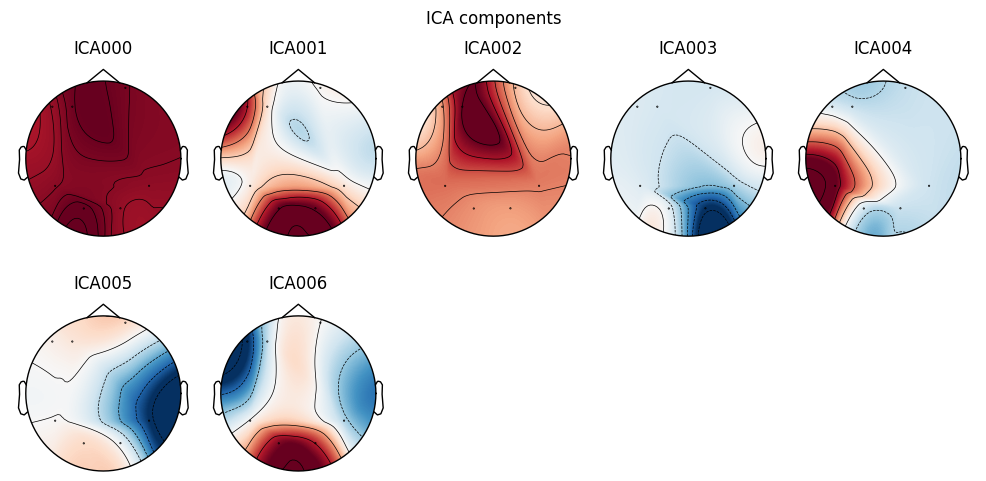

Creating RawArray with float64 data, n_channels=7, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.


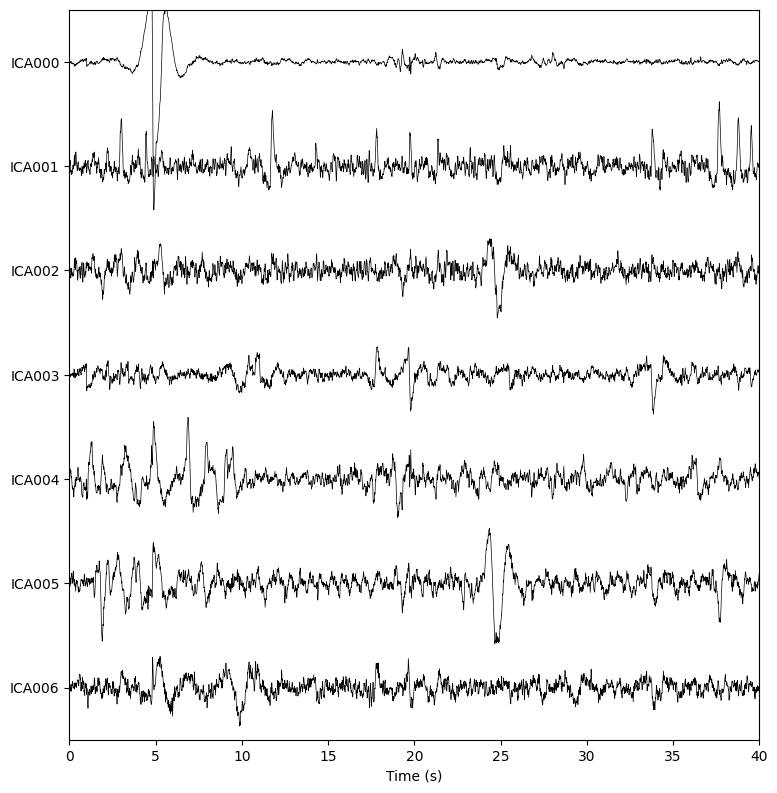

In [159]:
plot_ica_components(ica_full_data, raw_full_data)

Vẽ các thành phần ICA cho file thứ 3


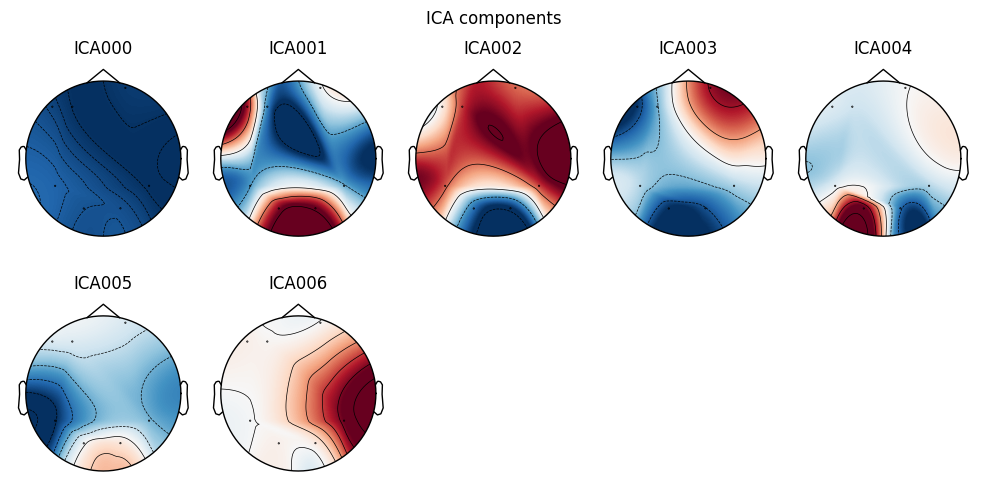

Creating RawArray with float64 data, n_channels=7, n_times=357224
    Range : 0 ... 357223 =      0.000 ...  2790.805 secs
Ready.


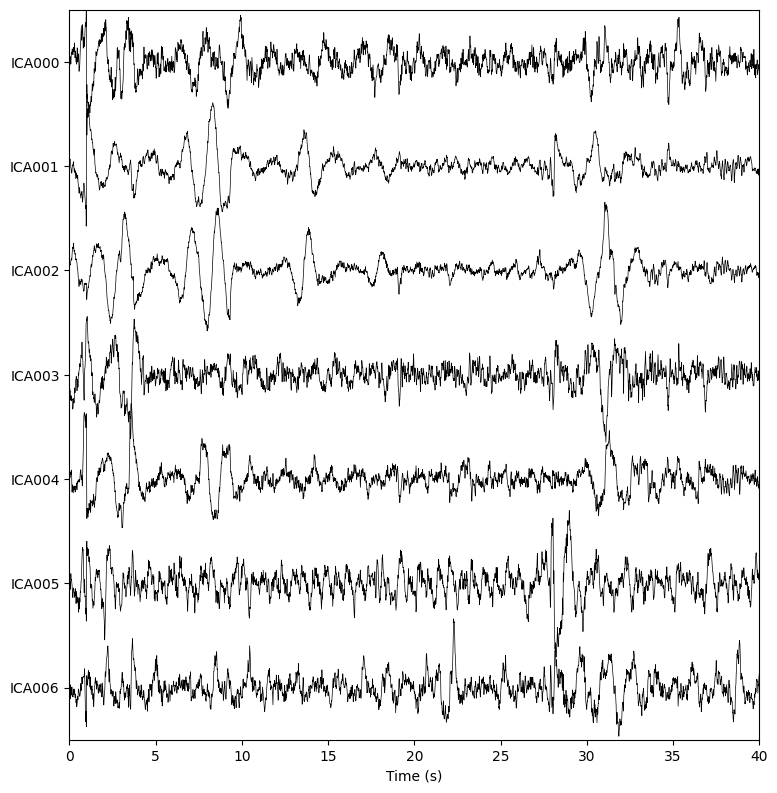

Vẽ các thành phần ICA cho file thứ 10


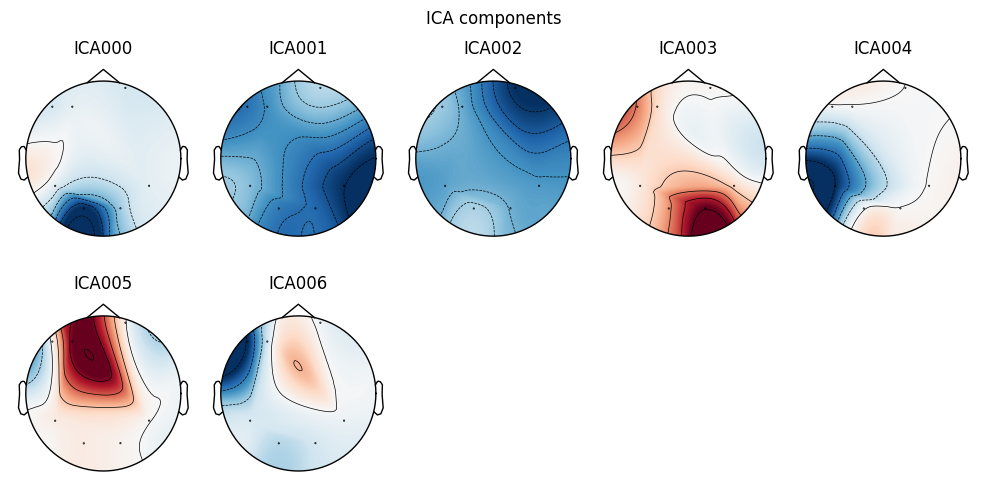

Creating RawArray with float64 data, n_channels=7, n_times=398816
    Range : 0 ... 398815 =      0.000 ...  3115.742 secs
Ready.


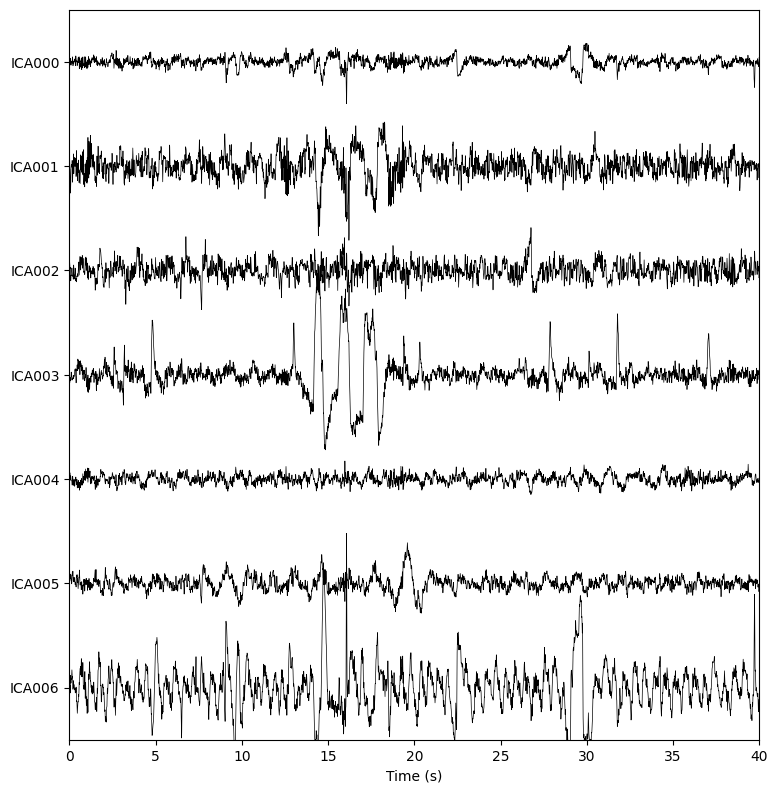

In [160]:
plot_ica_components(ica_reduce_data, raw_reduce_data, num_files=2, reduce=True)

**Phát hiện nhiễu EOG và ECG**

* **EOG artifacts:** Các tín hiệu EOG phát sinh khi mắt chuyển động (ví dụ, nháy mắt hoặc chuyển động mắt theo hướng khác) gây ra dòng điện nhỏ có thể ghi nhận được trên da gần mắt. Các tín hiệu này có thể ảnh hưởng đến tín hiệu EEG, làm cho việc phân tích sóng não trở nên khó khăn hơn.

* **ECG artifacts:** Các nhiễu ECG xuất hiện khi tín hiệu của tim (bao gồm các sóng điện học phát sinh từ hoạt động của tim) xâm nhập vào các kênh EEG. Những nhiễu này có thể làm méo tín hiệu não và cần được phát hiện và loại bỏ.

In [161]:
def detect_eog_artifacts(ica, raw, eye_channels):
    all_eog_indices = {}

    for ch in eye_channels:
        if ch in raw.ch_names:  # Kiểm tra nếu kênh có tồn tại trong đối tượng Raw
            try:
                # Phát hiện nhiễu nháy mắt (EOG)
                eog_indices, _ = ica.find_bads_eog(raw, ch_name=ch)
                all_eog_indices[ch] = eog_indices
                # print(f"Các thành phần ICA liên quan đến nháy mắt với kênh {ch}: {eog_indices}")
            except Exception as e:
                print(f"Lỗi khi chạy với kênh {ch}: {e}")

    return all_eog_indices

def detect_ecg_artifacts(ica, raw, heart_related_channels):
    all_ecg_indices = {}

    for ch in heart_related_channels:
        if ch in raw.ch_names:  # Kiểm tra nếu kênh có tồn tại trong đối tượng Raw
            try:
                # Phát hiện nhiễu nhịp tim (ECG)
                ecg_indices, _ = ica.find_bads_ecg(raw, ch_name=ch)
                all_ecg_indices[ch] = ecg_indices
                # print(f"Các thành phần ICA liên quan đến nhịp tim với kênh {ch}: {ecg_indices}")
            except Exception as e:
                print(f"Lỗi khi chạy với kênh {ch}: {e}")

    return all_ecg_indices

def print_indices_results(all_eog_indices, all_ecg_indices):
    # In kết quả EOG
    print("\nKết quả từ tất cả các kênh EOG:")
    for ch, indices in all_eog_indices.items():
        print(f"Kênh {ch}: Thành phần ICA {indices}")

    # In kết quả ECG
    print("\nKết quả từ tất cả các kênh ECG:")
    for ch, indices in all_ecg_indices.items():
        print(f"Kênh {ch}: Thành phần ICA {indices}")

In [162]:
def detect_artifacts(ica_list, raw_list):
    # Danh sách các kênh bị ảnh hưởng nhiễu từ mắt và tim
    eye_channels = ['F7']
    heart_channels = ['F7']

    eog_indices = []
    ecg_indices = []

    # Duyệt qua từng file trong raw_list và ica_list
    for i in range(len(raw_list)):
        print(f"\nKết quả cho file #{i + 1}:")
        
        # Phát hiện nhiễu EOG và ECG cho từng file
        eog = detect_eog_artifacts(ica_list[i], raw_list[i], eye_channels)
        ecg = detect_ecg_artifacts(ica_list[i], raw_list[i], heart_channels)

        eog_indices.append(eog)
        ecg_indices.append(ecg)


    return eog_indices, ecg_indices

In [163]:
eog_indices_full, ecg_indices_full = detect_artifacts(ica_full_data, raw_full_data)


Kết quả cho file #1:
Using EOG channel: F7
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff fr

In [164]:
eog_indices_reduce = get_data_5days(eog_indices_full)
ecg_indices_reduce = get_data_5days(ecg_indices_full)

In [165]:
def get_artifacts_table(eog_indices, ecg_indices, data_type="EOG"):
    
    # Khởi tạo danh sách các kênh
    channels = ['F7','F3','P7','O1','O2','P8','AF4']

    # Dữ liệu sẽ chứa thông tin từng chỉ số ICA bị nhiễu cho các kênh
    artifact_data = {channel: [] for channel in channels}

    # Duyệt qua từng file để lấy các chỉ số ICA nhiễu
    for artifact in (eog_indices if data_type == "EOG" else ecg_indices):
        for channel in channels:
            # Lấy các thành phần ICA bị nhiễu cho kênh này
            artifact_data[channel].append(artifact.get(channel, []))

    # Chuyển thành DataFrame
    artifact_df = pd.DataFrame(artifact_data)

    # Trả về bảng kết quả
    return artifact_df.transpose()  # Trả về DataFrame với mỗi file là một cột

# In kết quả EOG - Dữ liệu đầy đủ
eog_full_df = get_artifacts_table(eog_indices_full, ecg_indices_full, data_type="EOG")
print("Các chỉ số ICA bị nhiễu mắt (EOG) - Dữ liệu đầy đủ:")
print(eog_full_df)

# In kết quả EOG - Dữ liệu giảm
eog_reduce_df = get_artifacts_table(eog_indices_reduce, ecg_indices_reduce, data_type="EOG")
print("\nCác chỉ số ICA bị nhiễu mắt (EOG) - Dữ liệu giảm:")
print(eog_reduce_df)

# In kết quả ECG - Dữ liệu đầy đủ
ecg_full_df = get_artifacts_table(eog_indices_full, ecg_indices_full, data_type="ECG")
print("\nCác chỉ số ICA bị nhiễu tim (ECG) - Dữ liệu đầy đủ:")
print(ecg_full_df)

# In kết quả ECG - Dữ liệu giảm
ecg_reduce_df = get_artifacts_table(eog_indices_reduce, ecg_indices_reduce, data_type="ECG")
print("\nCác chỉ số ICA bị nhiễu tim (ECG) - Dữ liệu giảm:")
print(ecg_reduce_df)

Các chỉ số ICA bị nhiễu mắt (EOG) - Dữ liệu đầy đủ:
     0   1   2   3   4   5   6   7   8   9   ...  58  59  60  61  62  63  64  \
F7   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
F3   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
P7   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
O1   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
O2   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
P8   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
AF4  []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   

     65  66  67  
F7   []  []  []  
F3   []  []  []  
P7   []  []  []  
O1   []  []  []  
O2   []  []  []  
P8   []  []  []  
AF4  []  []  []  

[7 rows x 68 columns]

Các chỉ số ICA bị nhiễu mắt (EOG) - Dữ liệu giảm:
     0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  19  20  \
F7   []  

In [166]:
def exclude_ica_components_for_all(ica_list, raw_list, eog_indices_list, ecg_indices_list):

    excluded_raw_list = []
    excluded_ica_list = []

    for idx, ica in enumerate(ica_list):
        print(f"\nĐang loại bỏ thành phần ICA cho file #{idx + 1}:")
        
        # Lấy chỉ số EOG và ECG cho từng file
        eog_indices = eog_indices_list[idx]
        ecg_indices = ecg_indices_list[idx]
        
        # Tạo bản sao của raw để giữ dữ liệu gốc và dữ liệu đã loại trừ riêng biệt
        raw_copy = raw_list[idx].copy()

        # Loại bỏ các thành phần ICA cho EOG và ECG
        all_exclude_indices = []
        
        # Thêm các thành phần ICA bị nhiễu EOG và ECG vào danh sách loại trừ
        for eog in eog_indices.values():  # Duyệt qua các chỉ số EOG
            all_exclude_indices.extend(eog)
        
        for ecg in ecg_indices.values():  # Duyệt qua các chỉ số ECG
            all_exclude_indices.extend(ecg)
        
        # Loại bỏ các thành phần ICA trong ica.exclude
        ica.exclude = list(set(all_exclude_indices))  # Loại bỏ trùng lặp
        print(f"Đã loại bỏ các thành phần ICA: {ica.exclude}")
        
        # Áp dụng ICA sau khi loại trừ
        ica.apply(raw_copy)  # Áp dụng loại trừ vào bản sao của raw

        # Thêm dữ liệu đã loại trừ vào danh sách kết quả
        excluded_raw_list.append(raw_copy)
        excluded_ica_list.append(ica)  # Lưu lại đối tượng ICA đã loại trừ

        print(f"Đã loại trừ thành công cho file #{idx + 1}")
    
    return excluded_ica_list ,excluded_raw_list

# Sử dụng với dữ liệu đầy đủ (full_data) và dữ liệu giảm (reduce_data)
excluded_ica_full, excluded_raw_full = exclude_ica_components_for_all(ica_full_data, raw_full_data, eog_indices_full, ecg_indices_full)

# excluded_raw_reduce_data = exclude_ica_components_for_all(ica_reduce_data, raw_reduce_data, eog_indices_reduce, ecg_indices_reduce)
excluded_ica_reduce = get_data_5days(excluded_ica_full)
excluded_raw_reduce = get_data_5days(excluded_raw_full)


Đang loại bỏ thành phần ICA cho file #1:
Đã loại bỏ các thành phần ICA: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Đã loại trừ thành công cho file #1

Đang loại bỏ thành phần ICA cho file #2:
Đã loại bỏ các thành phần ICA: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Đã loại trừ thành công cho file #2

Đang loại bỏ thành phần ICA cho file #3:
Đã loại bỏ các thành phần ICA: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Đã loại trừ thành công cho file #3

Đang loại bỏ thành phần ICA cho file #4:
Đã loại bỏ các thành phần ICA: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA co

Vẽ các thành phần ICA cho file thứ 1


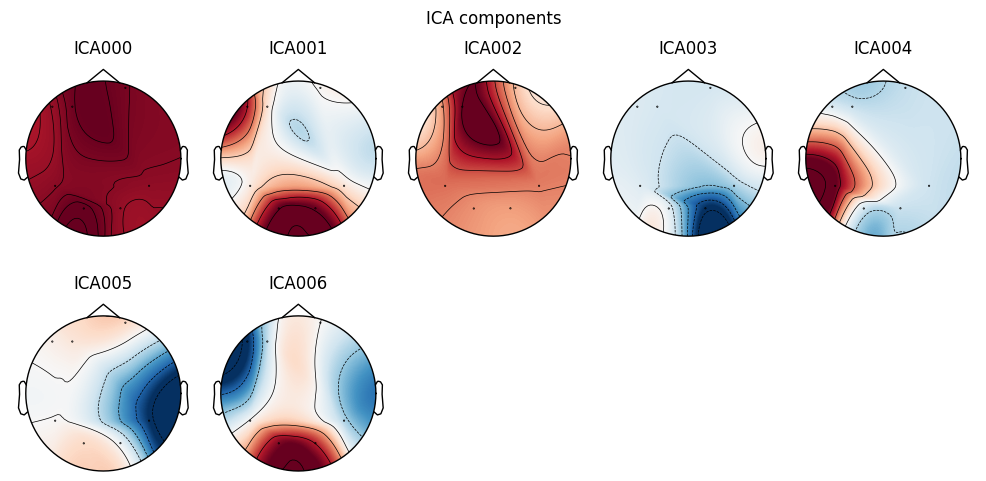

Creating RawArray with float64 data, n_channels=7, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.


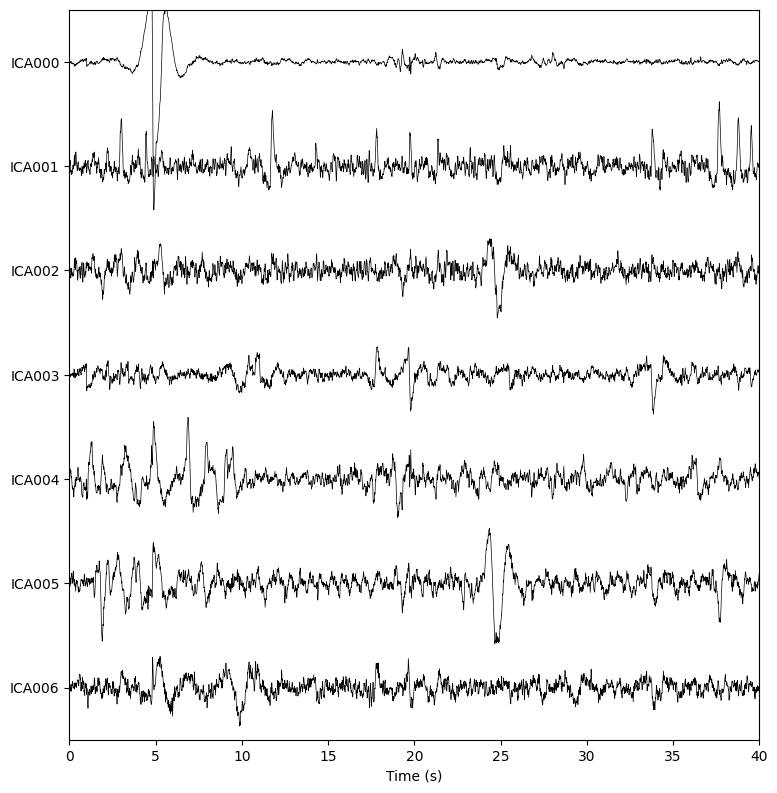

Vẽ các thành phần ICA cho file thứ 2


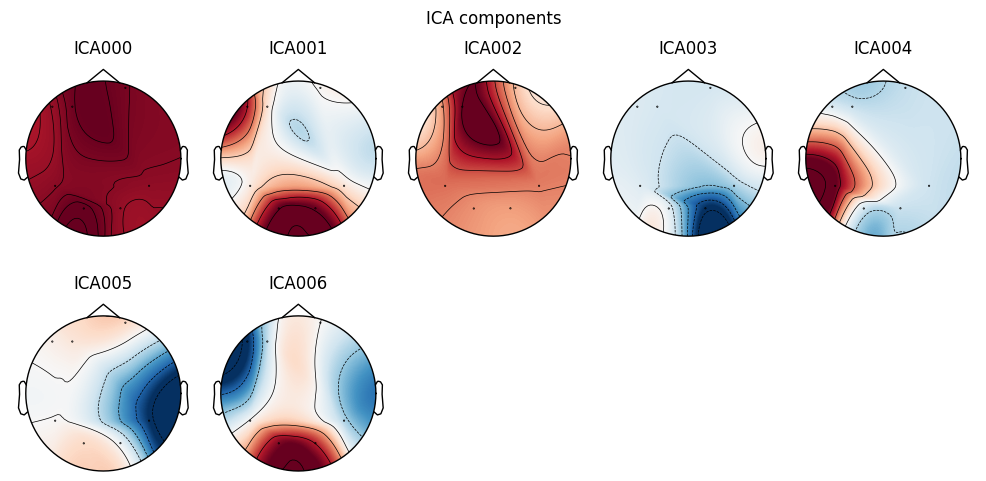

Creating RawArray with float64 data, n_channels=7, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.


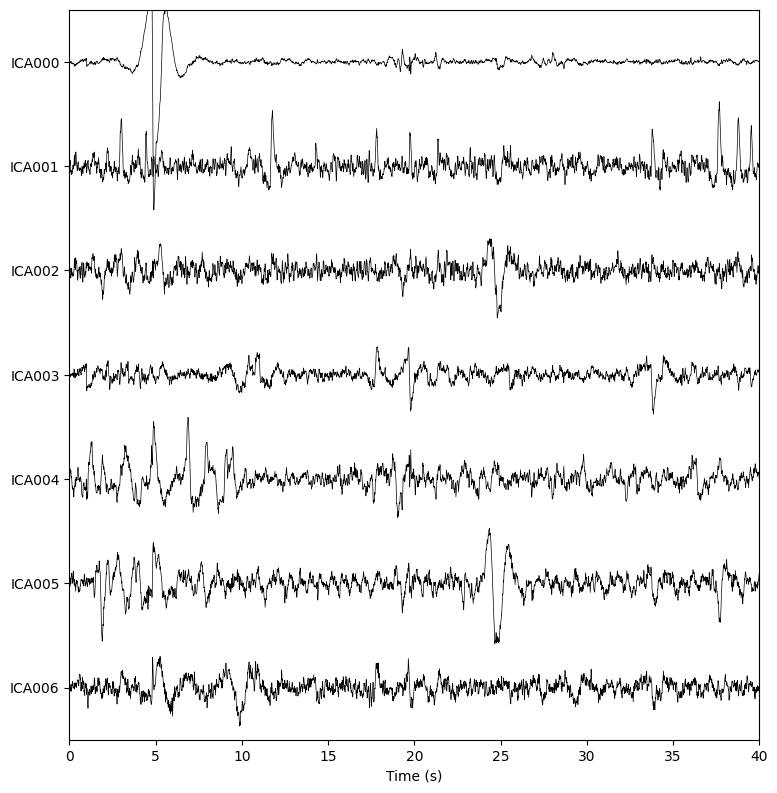

In [167]:
plot_ica_components(ica_full_data, raw_full_data)

Vẽ các thành phần ICA cho file thứ 1


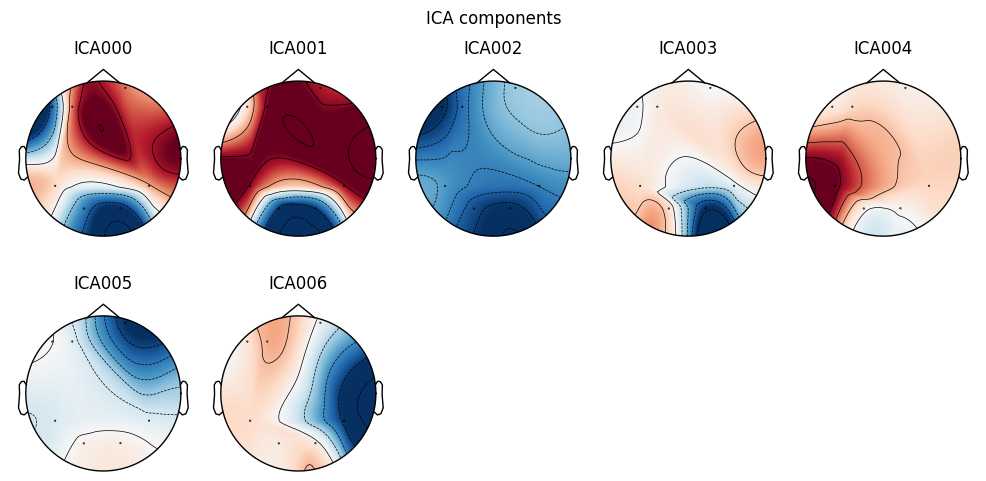

Creating RawArray with float64 data, n_channels=7, n_times=366020
    Range : 0 ... 366019 =      0.000 ...  2859.523 secs
Ready.


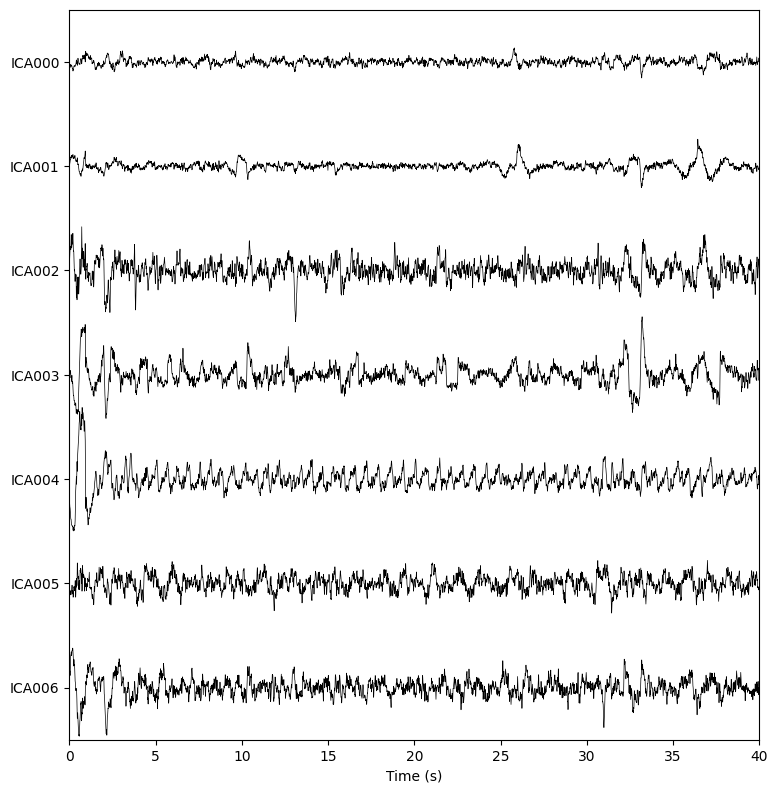

Vẽ các thành phần ICA cho file thứ 2


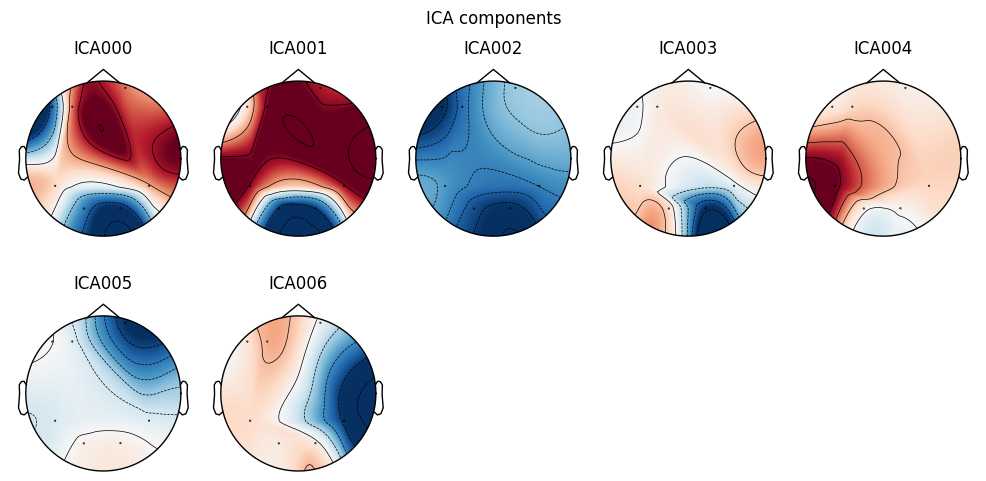

Creating RawArray with float64 data, n_channels=7, n_times=366020
    Range : 0 ... 366019 =      0.000 ...  2859.523 secs
Ready.


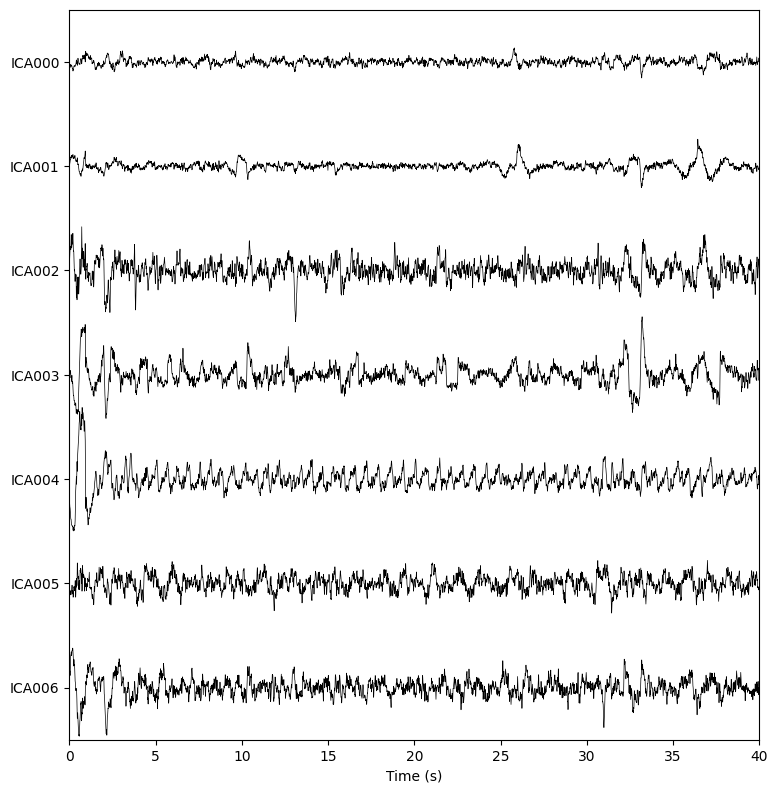

In [168]:
plot_ica_components(ica_reduce_data, raw_reduce_data)

In [169]:
# Lưu dữ liệu vào một dictionary với keys là 'file_1', 'file_2', ...
full_data_ICA = {}
reduce_data_ICA = {}

for idx, raw in enumerate(excluded_raw_full):
    file_key = f"file_{idx + 1}"  # Key cho từng file (file_1, file_2, ...)
    full_data_ICA[file_key] = raw.get_data().T  # Lưu dữ liệu của file vào dictionary

for idx, raw in enumerate(excluded_raw_reduce):
    file_key = f"file_{idx + 1}"  # Key cho từng file (file_1, file_2, ...)
    reduce_data_ICA[file_key] = raw.get_data().T  # Lưu dữ liệu của file vào dictionary

In [170]:
# In thử data của 1 file 
full_data_ICA['file_1']

array([[ 6.57047172,  4.07116267,  4.02036296, ...,  5.81810913,
         4.35043234,  6.42530967],
       [ 7.64045213,  3.33447351,  7.0301308 , ...,  7.03656787,
         5.27359691,  8.16527911],
       [ 7.45826227,  2.11681028,  6.14721947, ...,  7.41534662,
         5.87179025,  6.53676764],
       ...,
       [20.2435573 , 16.1707712 , 20.79365868, ..., 20.82856991,
         3.73162808, 15.26894109],
       [19.27838233, 15.29511581, 17.05681164, ..., 19.38353124,
         5.30686237, 14.8578989 ],
       [15.88845729, 15.10874383, 11.9387759 , ..., 16.63743163,
        13.00576218, 16.17590888]])

In [171]:
full_data_ICA['file_1'].shape

(308868, 7)

# Extract

In [172]:
def restructure_data(reduce_data_ICA, fs=128):

    # Tạo từ điển để lưu trữ dữ liệu
    data_dict = {
        'Focused': {},
        'Unfocused': {},
        'Drowsy': {}
    }

    # Định nghĩa số mẫu cho mỗi khoảng thời gian
    samples_per_minute = fs * 60  # Số mẫu trong 1 phút
    samples_10_minutes = samples_per_minute * 10  # Số mẫu trong 10 phút
    samples_20_minutes = samples_per_minute * 20  # Số mẫu trong 20 phút

    # Chia dữ liệu cho từng người và từng trạng thái
    for person_idx in range(5):
        # Tính chỉ số file bắt đầu và kết thúc cho mỗi người
        start_file_idx = person_idx * 5
        num_files = 5 if person_idx != 4 else 4

        # Lưu trữ dữ liệu cho mỗi người
        person_focus = []
        person_unfocus = []
        person_drowsy = []

        for file_idx in range(start_file_idx, start_file_idx + num_files):
            file_key = f"file_{file_idx + 1}"
            data = reduce_data_ICA[file_key]
            n_samples, n_channels = data.shape

            # Chia dữ liệu thành 3 phần: focused, unfocused, drowsy
            focus_data = data[:samples_10_minutes, :]
            unfocus_data = data[samples_10_minutes:samples_10_minutes * 2, :]
            drowsy_data = data[samples_10_minutes * 2:, :]

            # Thêm dữ liệu vào danh sách tương ứng cho mỗi trạng thái
            person_focus.append(focus_data)
            person_unfocus.append(unfocus_data)
            person_drowsy.append(drowsy_data)

        # Ghép tất cả các file lại thành một mảng duy nhất cho mỗi trạng thái
        subject_key = f"subject_{person_idx + 1}"
        data_dict['Focused'][subject_key] = np.concatenate(person_focus, axis=0)
        data_dict['Unfocused'][subject_key] = np.concatenate(person_unfocus, axis=0)
        data_dict['Drowsy'][subject_key] = np.concatenate(person_drowsy, axis=0)

    return data_dict

In [173]:
data_dict = restructure_data(reduce_data_ICA)

In [174]:
import numpy as np
from scipy.signal import stft

# 1. Hàm tạo cửa sổ Blackman-Harris
def create_blackman_harris_window(M=128):
    t_win = np.arange(0, M)
    window_blackman = 0.42 - 0.5 * np.cos((2 * np.pi * t_win) / (M - 1)) + 0.08 * np.cos((4 * np.pi * t_win) / (M - 1))
    return window_blackman

# 2. Hàm tính STFT và công suất phổ
def compute_stft_power(data, fs, window, nperseg, nfft=1024):
    f, t, Zxx = stft(data, fs=fs, window=window, nperseg=nperseg, noverlap=0, nfft=nfft,
                     detrend=False, return_onesided=True, boundary='zeros', padded=True)
    power = (np.abs(Zxx)) ** 2

    # Đảm bảo kết quả có 3 chiều: (num_channels, num_frequencies, num_segments)
    if power.ndim == 2:
        power = power[np.newaxis, :, :]  # Thêm chiều kênh nếu chỉ có 2 chiều
    return power

# 3. Hàm tính trung bình dải tần 0.5Hz
def combine_frequency_bins(power, num_bins=60, step=4):
    # Kiểm tra số chiều của power, đảm bảo power có ít nhất 3 chiều
    if len(power.shape) < 3:
        raise ValueError("Input 'power' must have at least 3 dimensions: (num_channels, num_frequencies, num_segments)")

    combined_power = np.zeros((power.shape[0], num_bins, power.shape[2]))
    for chn in range(power.shape[0]):
        for j, i in enumerate(range(0, step * num_bins, step)):
            if i + step <= power.shape[1]:
                combined_power[chn, j, :] = np.average(power[chn, i:i + step, :], axis=0)
            else:
                raise ValueError("Not enough frequency bins to combine")
    return combined_power

# 4. Hàm tính trung bình di động trên cửa sổ 15 giây
def moving_average_window(data, window_size=15):
    num_segments = data.shape[2] - window_size + 1
    averaged_data = np.zeros((data.shape[0], data.shape[1], num_segments))
    for chn in range(data.shape[0]):
        for j in range(num_segments):
            averaged_data[chn, :, j] = np.average(data[chn, :, j:j + window_size], axis=1)
    return averaged_data

# 5. Hàm chuyển đổi dữ liệu thành vector đặc trưng
def create_model_features(power_ave):
    num_channels = power_ave.shape[0]
    num_bins = power_ave.shape[1]
    num_segments = power_ave.shape[2]

    model_features = np.zeros((num_channels * num_bins, num_segments))
    for j in range(num_segments):
        model_features[:, j] = power_ave[:, :, j].reshape(-1)

    # Áp dụng logarit cho dữ liệu
    model_features = 10 * np.log(model_features)
    return model_features

def extract_features_from_data(data_dict, fs=128):
    # Lấy danh sách tên các đối tượng từ data_dict
    trail_names = list(data_dict['Focused'].keys())
    nperseg = 128
    window = create_blackman_harris_window(M=nperseg)

    power_focus = {}
    power_unfocus = {}
    power_drowsy = {}

    # Tính STFT và công suất phổ cho từng trạng thái
    for name in trail_names:
        power_focus[name] = []
        power_unfocus[name] = []
        power_drowsy[name] = []

        for i in range(data_dict['Focused'][name].shape[1]):
            # Sử dụng các khóa 'Focused', 'Unfocused', 'Drowsy' đúng với cấu trúc của data_dict
            power_focus_result = compute_stft_power(data_dict['Focused'][name][:, i], fs, window, nperseg)
            power_unfocus_result = compute_stft_power(data_dict['Unfocused'][name][:, i], fs, window, nperseg)
            power_drowsy_result = compute_stft_power(data_dict['Drowsy'][name][:, i], fs, window, nperseg)

            # Thêm kết quả STFT vào danh sách
            power_focus[name].append(power_focus_result)
            power_unfocus[name].append(power_unfocus_result)
            power_drowsy[name].append(power_drowsy_result)

        # Chuyển đổi danh sách thành mảng numpy với kích thước phù hợp
        power_focus[name] = np.concatenate(power_focus[name], axis=0)
        power_unfocus[name] = np.concatenate(power_unfocus[name], axis=0)
        power_drowsy[name] = np.concatenate(power_drowsy[name], axis=0)

    # Trung bình dải tần 0.5Hz
    power_focus_bin = {}
    power_unfocus_bin = {}
    power_drowsy_bin = {}

    for name in trail_names:
        power_focus_bin[name] = combine_frequency_bins(power_focus[name])
        power_unfocus_bin[name] = combine_frequency_bins(power_unfocus[name])
        power_drowsy_bin[name] = combine_frequency_bins(power_drowsy[name])

    # Trung bình di động trên cửa sổ 15 giây
    power_focus_ave = {}
    power_unfocus_ave = {}
    power_drowsy_ave = {}

    for name in trail_names:
        power_focus_ave[name] = moving_average_window(power_focus_bin[name])
        power_unfocus_ave[name] = moving_average_window(power_unfocus_bin[name])
        power_drowsy_ave[name] = moving_average_window(power_drowsy_bin[name])

    # Chuyển đổi thành vector đặc trưng cho SVM
    model_data_focus = {}
    model_data_unfocus = {}
    model_data_drowsy = {}

    for name in trail_names:
        model_data_focus[name] = create_model_features(power_focus_ave[name])
        model_data_unfocus[name] = create_model_features(power_unfocus_ave[name])
        model_data_drowsy[name] = create_model_features(power_drowsy_ave[name])

    return model_data_focus, model_data_unfocus, model_data_drowsy




In [175]:
model_data_focus, model_data_unfocus, model_data_drowsy = extract_features_from_data(data_dict)

In [176]:
model_data_drowsy['subject_1'].shape

(420, 8260)

In [177]:
# Hàm kết hợp dữ liệu và tạo nhãn cho từng trạng thái
def combine_data_with_labels(model_data_focus, model_data_unfocus, model_data_drowsy):
    # Lấy tất cả các tên đối tượng
    all_subjects = list(model_data_focus.keys())

    # Kết hợp dữ liệu của các trạng thái Not-Drowsy (Focused và Unfocused)
    X_focus = np.concatenate([model_data_focus[subject] for subject in all_subjects], axis=1)
    X_unfocus = np.concatenate([model_data_unfocus[subject] for subject in all_subjects], axis=1)
    X_drowsy = np.concatenate([model_data_drowsy[subject] for subject in all_subjects], axis=1)

    # Ghép tất cả các dữ liệu lại
    X = np.concatenate([X_focus, X_unfocus, X_drowsy], axis=1).T  # Chuyển vị để có dạng (n_samples, n_features)

    # Tạo nhãn cho từng trạng thái
    y_focus = ['Focused'] * X_focus.shape[1]  # Nhãn 'Focused' cho trạng thái Focused
    y_unfocus = ['Unfocused'] * X_unfocus.shape[1]  # Nhãn 'Unfocused' cho trạng thái Unfocused
    y_drowsy = ['Drowsy'] * X_drowsy.shape[1]  # Nhãn 'Drowsy' cho trạng thái Drowsy

    # Ghép tất cả các nhãn lại
    y = np.array(y_focus + y_unfocus + y_drowsy)

    return X, y

In [178]:
from sklearn.model_selection import train_test_split
X, y = combine_data_with_labels(model_data_focus, model_data_unfocus, model_data_drowsy)

In [179]:

# Tạo nhãn nhị phân cho Drowsy và Not-Drowsy
labels = np.array(['Drowsy' if label == 'Drowsy' else 'Not-drowsy' for label in y])

# Chia dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)

In [180]:
from sklearn.preprocessing import StandardScaler

# Scale dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit-transform trên tập train
X_test_scaled = scaler.transform(X_test)        # Transform trên tập test


In [181]:
from sklearn.decomposition import PCA
#Retain 90% of the dataset information
pca_train = PCA(.95)
pca_train.fit(X_train_scaled)

print("Dimension to keep 95% the information:", pca_train.n_components_)


Dimension to keep 95% the information: 47


In [182]:
X_train_pca = pca_train.transform(X_train_scaled)
X_test_pca = pca_train.transform(X_test_scaled)

In [183]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Huấn luyện SVM Drowsy vs Not-Drowsy
svm_binary = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm_binary.fit(X_train_pca, y_train)

SVC(random_state=42)

In [ ]:
# Dự đoán trên tập test
y_predict = svm_binary.predict(X_test_pca)

In [ ]:
print("\nĐánh giá trên tập test:")
print(classification_report(y_test, y_predict))

# Features Extract

In [ ]:
from scipy.signal import stft
from numpy import blackman
from scipy.stats import entropy

In [ ]:
# Hàm tính entropy phổ
def spectral_entropy(psd, freqs):
    psd_norm = psd / np.sum(psd)  # Chuẩn hóa công suất phổ
    psd_norm = np.clip(psd_norm, 1e-10, 1)  # Tránh log(0) bằng cách giới hạn giá trị nhỏ nhất
    return entropy(psd_norm)

# Hàm tính band power
def compute_band_power(psd, freqs, band):
    low, high = band
    band_idx = np.logical_and(freqs >= low, freqs <= high)
    return np.sum(psd[band_idx])  # Trả về tổng công suất trong dải tần

def extract_features(signal, fs, bands):
    # Áp dụng Blackman window
    t_win = np.arange(0, len(signal))
    M = len(signal)
    window = 0.42 - 0.5 * np.cos((2 * np.pi * t_win) / (M - 1)) + 0.08 * np.cos((4 * np.pi * t_win) / (M - 1))
    signal_windowed = signal * window
    
    # Tính STFT
    freqs, _, Zxx = stft(signal_windowed, fs, nperseg=fs * 2, window=window)
    psd = np.abs(Zxx)**2
    psd_mean = psd.mean(axis=1)  # Trung bình trên thời gian
    
    # Tính các đặc trưng
    total_power = np.sum(psd_mean)  # Tổng công suất trong tất cả các kênh và toàn bộ thời gian
    spectral_ent = spectral_entropy(psd_mean, freqs)
    
    # Median Frequency
    cumulative_power = np.cumsum(psd_mean)
    median_freq = freqs[np.where(cumulative_power >= 0.5 * total_power)[0][0]]
    
    # Peak Frequency
    peak_freq = freqs[np.argmax(psd_mean)]
    
    # Band power cho từng dải tần
    band_powers = {band: compute_band_power(psd_mean, freqs, band_range) for band, band_range in bands.items()}
    
    # Tạo kết quả đặc trưng
    features = {
        "Spectral_Entropy": spectral_ent,
        "Total_Power": total_power,
        "Median_Frequency": median_freq,
        "Peak_Frequency": peak_freq,
    }
    features.update(band_powers)
    return features

In [ ]:
# Hàm tính đặc trưng cho 1 file
def extract_one_file(file_key, data, fs, bands, segment_length, window_duration):
    results = []
    num_segments = data.shape[0] // segment_length  # Số phân đoạn

    for segment_idx in range(num_segments):
        segment = data[segment_idx * segment_length:(segment_idx + 1) * segment_length, :]
        
        # Xác định thời gian bắt đầu và kết thúc của phân đoạn
        segment_start_time = segment_idx * window_duration  # Thời gian bắt đầu (giây)
        segment_end_time = segment_start_time + window_duration  # Thời gian kết thúc (giây)
        
        # Gắn nhãn dựa trên thời gian
        if segment_start_time < 600:  # 10 phút đầu -> Focused
            label = "Focused"
        elif segment_start_time < 1200:  # 10 phút tiếp theo -> Unfocused
            label = "Unfocused"
        else:  # Phần còn lại -> Drowsy
            label = "Drowsy"
        
        for ch in range(segment.shape[1]):  # Duyệt qua từng kênh
            features = extract_features(segment[:, ch], fs, bands)
            features.update({
                "File": file_key,
                "Segment": segment_idx,
                "Channel": ch,
                "Label": label
            })
            results.append(features)
    
    return results

# # Hàm tính đặc trưng cho 1 file
# def extract_one_file(file_key, data, fs, bands, segment_length, window_duration):
#     results = []
#     num_segments = data.shape[0] // segment_length  # Số phân đoạn

#     # Giới hạn số phân đoạn để chỉ lấy dữ liệu trong 30 phút đầu
#     max_segments = 30 * 60 // window_duration  # 30 phút, mỗi phân đoạn có độ dài window_duration
#     num_segments = min(num_segments, max_segments)

#     # Đảm bảo mỗi nhãn có số lượng phân đoạn bằng nhau (10 phút cho mỗi nhãn)
#     segments_per_label = max_segments // 3  # 10 phút mỗi nhãn
    
#     for segment_idx in range(num_segments):
#         segment = data[segment_idx * segment_length:(segment_idx + 1) * segment_length, :]

#         # Xác định thời gian bắt đầu của phân đoạn
#         segment_start_time = segment_idx * window_duration  # Thời gian bắt đầu (giây)

#         # Gắn nhãn dựa trên thời gian và đảm bảo tính cân bằng
#         if segment_idx < segments_per_label:  # 10 phút đầu -> Focused
#             label = "Focused"
#         elif segment_idx < 2 * segments_per_label:  # 10 phút tiếp theo -> Unfocused
#             label = "Unfocused"
#         else:  # 10 phút tiếp theo -> Drowsy
#             label = "Drowsy"

#         for ch in range(segment.shape[1]):  # Duyệt qua từng kênh
#             features = extract_features(segment[:, ch], fs, bands)
#             features.update({
#                 "File": file_key,
#                 "Segment": segment_idx,
#                 "Channel": ch,
#                 "Label": label
#             })
#             results.append(features)

#     return results


# Hàm tính đặc trưng cho tất cả các file
def extract_all_files(full_data_ICA, fs, bands, segment_length, window_duration):
    all_results = []
    
    for file_key, data in full_data_ICA.items():
        file_results = extract_one_file(file_key, data, fs, bands, segment_length, window_duration)
        all_results.extend(file_results)
    
    # Chuyển kết quả thành DataFrame
    features_df = pd.DataFrame(all_results)

    # # Lưu ra file CSV
    # features_df.to_csv("EEG_features_full_data.csv", index=False)
    # print("Đặc trưng đã được trích xuất, gắn nhãn và lưu vào file 'EEG_features_full_data.csv'")

    features_df.to_csv("EEG_features_reduce_data_imbalance.csv", index=False)
    print("Đặc trưng đã được trích xuất, gắn nhãn và lưu vào file 'EEG_features_reduce_data_imbalance.csv'")

    return features_df

In [ ]:
# Định nghĩa các dải tần
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30)
}

# Tần số lấy mẫu (sampFreq)
fs = 128  # Hz
window_duration = 15  # Giây
segment_length = fs * window_duration  # Số mẫu mỗi phân đoạn

In [ ]:
results_reduce = extract_all_files(reduce_data_ICA, fs, bands, segment_length, window_duration)

# Extract

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import stft
from numpy import blackman
from scipy.stats import entropy

# Hàm tính entropy phổ
def spectral_entropy(psd, freqs):
    psd_norm = psd / np.sum(psd)  # Chuẩn hóa công suất phổ
    psd_norm = np.clip(psd_norm, 1e-10, 1)  # Tránh log(0) bằng cách giới hạn giá trị nhỏ nhất
    return entropy(psd_norm)

# Hàm tính band power
def compute_band_power(psd, freqs, band):
    low, high = band
    band_idx = np.logical_and(freqs >= low, freqs <= high)
    return np.sum(psd[band_idx])  # Trả về tổng công suất trong dải tần

def extract_features(signal, fs, bands):
    # Áp dụng Blackman window
    window = blackman(len(signal))
    signal_windowed = signal * window
    
    # Tính STFT
    freqs, _, Zxx = stft(signal_windowed, fs, nperseg=fs * 15)  # Dùng cửa sổ 15 giây
    psd = np.abs(Zxx) ** 2
    psd_mean = psd.mean(axis=1)  # Trung bình trên thời gian
    
    # Tính các đặc trưng
    total_power = np.sum(psd_mean)  # Tổng công suất trong tất cả các kênh và toàn bộ thời gian
    spectral_ent = spectral_entropy(psd_mean, freqs)
    
    # Median Frequency
    cumulative_power = np.cumsum(psd_mean)
    median_freq = freqs[np.where(cumulative_power >= 0.5 * total_power)[0][0]]
    
    # Peak Frequency
    peak_freq = freqs[np.argmax(psd_mean)]
    
    # Band power cho từng dải tần
    band_powers = {band: compute_band_power(psd_mean, freqs, band_range) for band, band_range in bands.items()}
    
    # Tạo kết quả đặc trưng
    features = {
        "Spectral_Entropy": spectral_ent,
        "Total_Power": total_power,
        "Median_Frequency": median_freq,
        "Peak_Frequency": peak_freq,
    }
    features.update(band_powers)
    return features

In [ ]:
# Hàm tính đặc trưng cho 1 file
def extract_one_file(file_key, data, fs, bands, segment_length, window_duration):
    results = []
    num_segments = data.shape[0] // segment_length  # Số phân đoạn

    for segment_idx in range(num_segments):
        segment = data[segment_idx * segment_length:(segment_idx + 1) * segment_length, :]
        
        # Xác định thời gian bắt đầu và kết thúc của phân đoạn
        segment_start_time = segment_idx * window_duration  # Thời gian bắt đầu (giây)
        segment_end_time = segment_start_time + window_duration  # Thời gian kết thúc (giây)
        
        # Gắn nhãn dựa trên thời gian
        if segment_start_time < 600:  # 10 phút đầu -> Focused
            label = "Focused"
        elif segment_start_time < 1200:  # 10 phút tiếp theo -> Unfocused
            label = "Unfocused"
        else:  # Phần còn lại -> Drowsy
            label = "Drowsy"
        
        for ch in range(segment.shape[1]):  # Duyệt qua từng kênh
            features = extract_features(segment[:, ch], fs, bands)
            features.update({
                "File": file_key,
                "Segment": segment_idx,
                "Channel": ch,
                "Label": label
            })
            results.append(features)
    
    return results

# # Hàm tính đặc trưng cho 1 file
# def extract_one_file(file_key, data, fs, bands, segment_length, window_duration):
#     results = []
#     num_segments = data.shape[0] // segment_length  # Số phân đoạn

#     # Giới hạn số phân đoạn để chỉ lấy dữ liệu trong 30 phút đầu
#     max_segments = 30 * 60 // window_duration  # 30 phút, mỗi phân đoạn có độ dài window_duration
#     num_segments = min(num_segments, max_segments)

#     # Đảm bảo mỗi nhãn có số lượng phân đoạn bằng nhau (10 phút cho mỗi nhãn)
#     segments_per_label = max_segments // 3  # 10 phút mỗi nhãn
    
#     for segment_idx in range(num_segments):
#         segment = data[segment_idx * segment_length:(segment_idx + 1) * segment_length, :]

#         # Xác định thời gian bắt đầu của phân đoạn
#         segment_start_time = segment_idx * window_duration  # Thời gian bắt đầu (giây)

#         # Gắn nhãn dựa trên thời gian và đảm bảo tính cân bằng
#         if segment_idx < segments_per_label:  # 10 phút đầu -> Focused
#             label = "Focused"
#         elif segment_idx < 2 * segments_per_label:  # 10 phút tiếp theo -> Unfocused
#             label = "Unfocused"
#         else:  # 10 phút tiếp theo -> Drowsy
#             label = "Drowsy"

#         for ch in range(segment.shape[1]):  # Duyệt qua từng kênh
#             features = extract_features(segment[:, ch], fs, bands)
#             features.update({
#                 "File": file_key,
#                 "Segment": segment_idx,
#                 "Channel": ch,
#                 "Label": label
#             })
#             results.append(features)

#     return results

In [ ]:
# Hàm tính đặc trưng cho tất cả các file
def extract_all_files(full_data_ICA, fs, bands, segment_length, window_duration):
    all_results = []
    
    for file_key, data in full_data_ICA.items():
        file_results = extract_one_file(file_key, data, fs, bands, segment_length, window_duration)
        all_results.extend(file_results)
    
    # Chuyển kết quả thành DataFrame
    features_df = pd.DataFrame(all_results)

    # Lưu ra file CSV
    features_df.to_csv("Reduce_data_no_balance.csv", index=False)
    print("Đặc trưng đã được trích xuất, gắn nhãn và lưu vào file 'Reduce_data_no_balance.csv'")

    return features_df

In [ ]:
# Định nghĩa các dải tần
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 18)  # Giới hạn Beta từ 13-18 Hz để phù hợp với dải tần 0-18 Hz
}

# Tần số lấy mẫu (sampFreq)
fs = 128  # Hz
window_duration = 15  # Giây
segment_length = fs * window_duration  # Số mẫu mỗi phân đoạn


In [ ]:
results_reduce = extract_all_files(reduce_data_ICA, fs, bands, segment_length, window_duration)

# Model FULL DATA

In [ ]:
import pandas as pd

# Đọc file CSV
file_path = "EEG_features_labels.csv" 
results = pd.read_csv(file_path)

In [ ]:
label_counts = results["Label"].value_counts()
print("Phân phối số lượng mẫu theo trạng thái:")
print(label_counts)

In [ ]:
features = results.drop(columns=["File", "Segment", "Channel"])

In [ ]:
features.describe()

In [ ]:
features.shape

In [ ]:
import seaborn as sns

# Vẽ Boxplot cho từng cột
plt.figure(figsize=(16, 10))
for i, col in enumerate(features.columns):
    plt.subplot(3, 3, i+1)  # Tạo các subplot
    sns.boxplot(y=features[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


In [ ]:
features = features.drop(features[features['Total_Power'] >= 25000].index)
features = features.drop(features[features['Median_Frequency'] >= 20].index)
features = features.drop(features[features['Peak_Frequency'] >= 20].index)
features = features.drop(features[features['Delta'] >= 20000].index)
features = features.drop(features[features['Theta'] >= 2500].index)
features = features.drop(features[features['Alpha'] >= 500].index)
features = features.drop(features[features['Beta'] >= 400].index)

In [ ]:
# Tính ma trận tương quan
correlation = features.iloc[:,:8].corr()

# Vẽ heatmap cho ma trận tương quan
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan giữa các đặc trưng")
plt.show()

In [ ]:
new_features = features.drop(columns=['Total_Power'])
new_features.head()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

new_features = features.drop(columns=['Total_Power', 'Label'])

# Tạo nhãn nhị phân cho Drowsy và Undrowsy
labels = features['Label'].apply(lambda x: "Drowsy" if x == "Drowsy" else "Undrowsy")

# Chia dữ liệu thành tập train, val và test
X_train, X_temp, y_train, y_temp = train_test_split(
    new_features, labels, test_size=0.8, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Scale dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit-transform trên tập train
X_val_scaled = scaler.transform(X_val)          # Transform trên tập val
X_test_scaled = scaler.transform(X_test)        # Transform trên tập test


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Huấn luyện SVM Drowsy vs Not-Drowsy
svm_binary = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm_binary.fit(X_train_scaled, y_train)

# Dự đoán trên tập val
y_val_pred_binary = svm_binary.predict(X_val_scaled)
print("\nĐánh giá trên tập val (Drowsy vs Not-Drowsy):")
print(classification_report(y_val, y_val_pred_binary))

# Dự đoán trên tập test
y_test_pred_binary = svm_binary.predict(X_test_scaled)
print("\nĐánh giá trên tập test (Drowsy vs Not-Drowsy):")
print(classification_report(y_test, y_test_pred_binary))

# Model reduce data

In [ ]:
import pandas as pd

# Đọc file CSV
file_path_1 = "EEG_features_reduce_data_imbalance.csv" 
results_1 = pd.read_csv(file_path_1)

In [ ]:
label_counts_1 = results_1["Label"].value_counts()
print("Phân phối số lượng mẫu theo trạng thái:")
print(label_counts_1)

In [ ]:
features_1 = results_1.drop(columns=["File", "Segment", "Channel"])

In [ ]:
features_1.describe()

In [ ]:
import seaborn as sns

# Vẽ Boxplot cho từng cột
plt.figure(figsize=(16, 10))
for i, col in enumerate(features_1.iloc[:,:8].columns):
    plt.subplot(3, 3, i+1)  # Tạo các subplot
    sns.boxplot(y=features_1[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


In [ ]:
features_1 = features_1.drop(features_1[features_1['Total_Power'] >= 25000].index)
# features_1 = features_1.drop(features_1[features_1['Median_Frequency'] >= 20].index)
features_1 = features_1.drop(features_1[features_1['Peak_Frequency'] >= 4].index)
features_1 = features_1.drop(features_1[features_1['Delta'] >= 50000].index)
features_1 = features_1.drop(features_1[features_1['Theta'] >= 2000].index)
features_1 = features_1.drop(features_1[features_1['Alpha'] >= 1000].index)
features_1 = features_1.drop(features_1[features_1['Beta'] >= 1000].index)

In [ ]:
# Tính ma trận tương quan
correlation_1 = features_1.iloc[:,:8].corr()

# Vẽ heatmap cho ma trận tương quan
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_1, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan giữa các đặc trưng")
plt.show()

In [ ]:
features_1 = features_1.drop(columns=['Total_Power', 'Spectral_Entropy'])

# 3 SVM

In [ ]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu cho Drowsy vs Not-Drowsy
labels_drowsy = features_1["Label"].apply(lambda x: "Drowsy" if x == "Drowsy" else "Not-Drowsy")
X_train_drowsy, X_test_drowsy, y_train_drowsy, y_test_drowsy = train_test_split(
    features_1.drop(columns=["Label"]), labels_drowsy, test_size=0.2, random_state=42, stratify=labels_drowsy
)

# Chia dữ liệu cho Focused vs Not-Focused
labels_focused = features_1["Label"].apply(lambda x: "Focused" if x == "Focused" else "Not-Focused")
X_train_focused, X_test_focused, y_train_focused, y_test_focused = train_test_split(
    features_1.drop(columns=["Label"]), labels_focused, test_size=0.2, random_state=42, stratify=labels_focused
)

# Chia dữ liệu cho Unfocused vs Not-Unfocused
labels_unfocused = features_1["Label"].apply(lambda x: "Unfocused" if x == "Unfocused" else "Not-Unfocused")
X_train_unfocused, X_test_unfocused, y_train_unfocused, y_test_unfocused = train_test_split(
    features_1.drop(columns=["Label"]), labels_unfocused, test_size=0.2, random_state=42, stratify=labels_unfocused
)

In [ ]:
# Scale dữ liệu Drowsy
scaler_drowsy = StandardScaler()
X_train_drowsy_scaled = scaler_drowsy.fit_transform(X_train_drowsy)
X_test_drowsy_scaled = scaler_drowsy.transform(X_test_drowsy)

# Scale dữ liệu Focused
scaler_focused = StandardScaler()
X_train_focused_scaled = scaler_focused.fit_transform(X_train_focused)
X_test_focused_scaled = scaler_focused.transform(X_test_focused)

# Scale dữ liệu unFocused
scaler_unfocused = StandardScaler()
X_train_unfocused_scaled = scaler_unfocused.fit_transform(X_train_focused)
X_test_unfocused_scaled = scaler_unfocused.transform(X_test_focused)

In [ ]:
from sklearn.svm import SVC

# Huấn luyện SVM Drowsy vs Not-Drowsy
svm_drowsy = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm_drowsy.fit(X_train_drowsy_scaled, y_train_drowsy)

# Huấn luyện SVM Focused vs Not-Focused
svm_focused = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm_focused.fit(X_train_focused_scaled, y_train_focused)

# Huấn luyện SVM Unfocused vs Not-Unfocused
svm_unfocused = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm_unfocused.fit(X_train_unfocused_scaled, y_train_unfocused)


In [ ]:
# Dự đoán với từng mô hình SVM trên tập kiểm tra chung
y_pred_drowsy = svm_drowsy.predict(X_test_drowsy_scaled)
y_pred_focused = svm_focused.predict(X_test_focused_scaled)
y_pred_unfocused = svm_unfocused.predict(X_test_unfocused_scaled)

# Áp dụng XOR-Aggregation để kết hợp kết quả
y_final_pred = []

for p_drowsy, p_focused, p_unfocused in zip(y_pred_drowsy, y_pred_focused, y_pred_unfocused):
    if p_drowsy == "Drowsy" and p_focused == "Not-Focused" and p_unfocused == "Not-Unfocused":
        y_final_pred.append("Drowsy")
    elif p_drowsy == "Not-Drowsy" and p_focused == "Focused" and p_unfocused == "Not-Unfocused":
        y_final_pred.append("Focused")
    elif p_drowsy == "Not-Drowsy" and p_focused == "Not-Focused" and p_unfocused == "Unfocused":
        y_final_pred.append("Unfocused")
    else:
        y_final_pred.append("Unclassified")


In [ ]:
# In kết quả
print("Báo cáo kết quả phân loại:")
print(classification_report(y_test_focused, y_final_pred))  # Bạn có thể chọn tập y_test tương ứng để so sánh


# SVM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

new_features_1 = features_1.drop(columns=['Label'])

# Tạo nhãn nhị phân cho Drowsy và Undrowsy
labels_1 = features_1['Label'].apply(lambda x: "Drowsy" if x == "Drowsy" else "Undrowsy")

# label_encoder = LabelEncoder()
# labels_1_encoded = label_encoder.fit_transform(labels_1)

# Chia dữ liệu thành tập train, val và test
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    new_features_1, labels_1, test_size=0.3, random_state=42, stratify=labels_1
)

# X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(
#     X_temp_1, y_temp_1, test_size=0.5, random_state=42, stratify=y_temp_1
# )

# Scale dữ liệu
scaler_1 = StandardScaler()
X_train_scaled_1 = scaler_1.fit_transform(X_train_1)  # Fit-transform trên tập train
# X_val_scaled_1 = scaler_1.transform(X_val_1)          # Transform trên tập val
X_test_scaled_1 = scaler_1.transform(X_test_1)        # Transform trên tập test


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Huấn luyện SVM Drowsy vs Not-Drowsy
svm_binary_1 = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm_binary_1.fit(X_train_scaled_1, y_train_1)

In [ ]:
# # Dự đoán trên tập val
# y_val_pred_binary_1 = svm_binary_1.predict(X_val_scaled_1)
# print("\nĐánh giá trên tập val (Drowsy vs Not-Drowsy):")
# print(classification_report(y_val_1, y_val_pred_binary_1))

# Dự đoán trên tập test
y_test_pred_binary_1 = svm_binary_1.predict(X_test_scaled_1)

In [ ]:
print("\nĐánh giá trên tập test:")
print(classification_report(y_test_1, y_test_pred_binary_1))